---
layout: post
title:  "Gaussian Processes: A Python tutorial and introduction!"
short_title: "An Introduction to Gaussian Processes"
desc: "Welcome to the wonderful world of non-parametric models and kernel functions."
long_desc: "In this article, we'll introduce Gaussian Processes, how they work conceptually using Python examples, and how you can fit and train one to use in your data analysis problems."
date: ###DATE
categories: [tutorial]
tags: [statistics]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/gaussian_processes"

math: true
---

In this little write up, we'll explore, construct and utilise Gaussian Processes for some simple interpolation models. The goal is - at the end - to know how they work under the hood, how they are trained, and how you can use them in weird and wonderful ways.

I'll go through some basic interpolation, covariance and correlation concepts first. If they're all familiar to you, scroll down the Gaussian Process section.

# Introduction

To get the basics, we'll cover a) generating some data to play with, b) constructing a covariance matrix, and c) how drawing random numbers using said covariance matrix enumlates a smooth process.

## Generating data

Let's do a tiny bit of leg work before jumping into Gaussian Processes in full. Let's get some data to use first before we complicate things! What we'll do now is define some *funky* function, and then visualise what it looks like. On top of that, we'll pick a few points on the function that we can treat like data samples.


In [1]:
# Remove
from base import *
plt.rcParams['axes.xmargin'] = 0.02
plt.rcParams['axes.ymargin'] = 0.02
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#8649e3', '#F77F00', '#2698eb', '#eb65b5', "#a1edcb"]) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))
import warnings
warnings.filterwarnings('ignore')

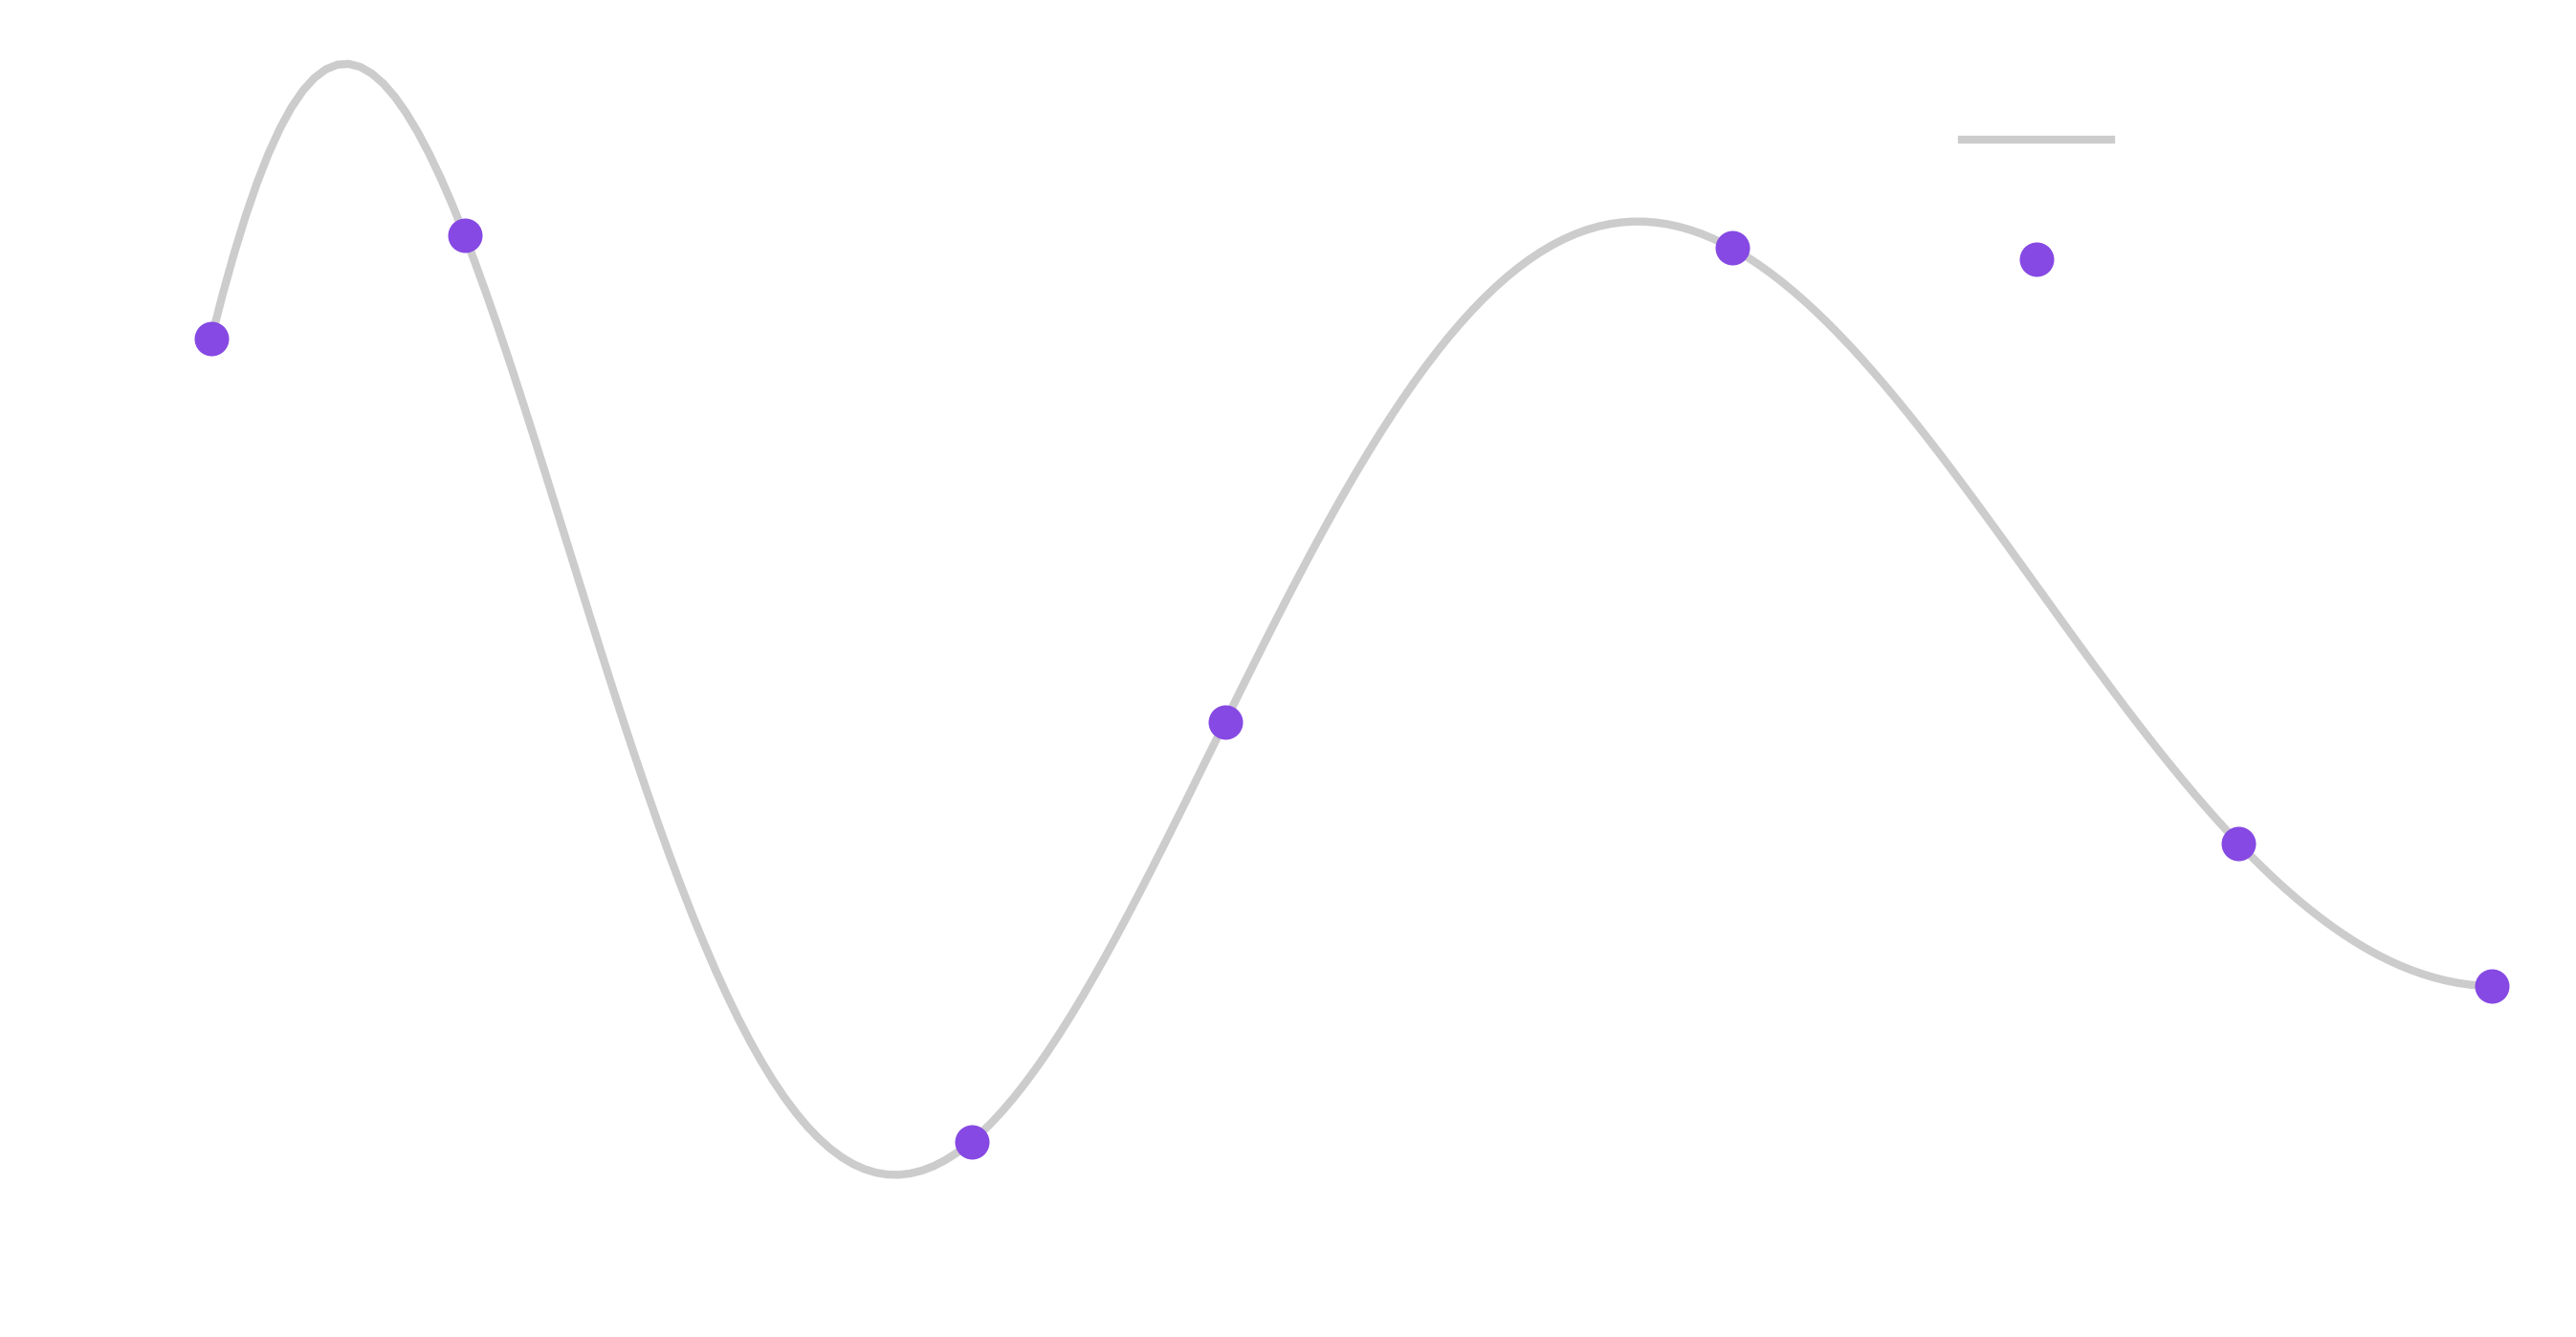

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Our funky function here
def fn(xs):
    return np.exp((xs + 10.5)**0.1) + np.sin(xs) / (xs + 1) + np.cos(2.5 * xs**0.5)**2

# Lets generate both the good visualisation of the function and some samples
xs = np.array([1, 2, 4, 5, 7, 9, 10])
x_fine = np.linspace(1, 10, 200)
ys, y_fine = fn(xs), fn(x_fine)

# And plot it out
plt.plot(x_fine, y_fine, c="#ccc", label="Function")
plt.scatter(xs, ys, s=30, label="Samples", zorder=20)
plt.legend();

Okay, so the idea here is that we are going to try and find some way of interpolating between the points we have (the samples), such that we can try and recover the underlying function in some way at least, but to do it in a way that **has** uncertainty on it.

## Traditional interpolation

Let's see what traditional methods look like, by using `scipy` to do basic interpolation:

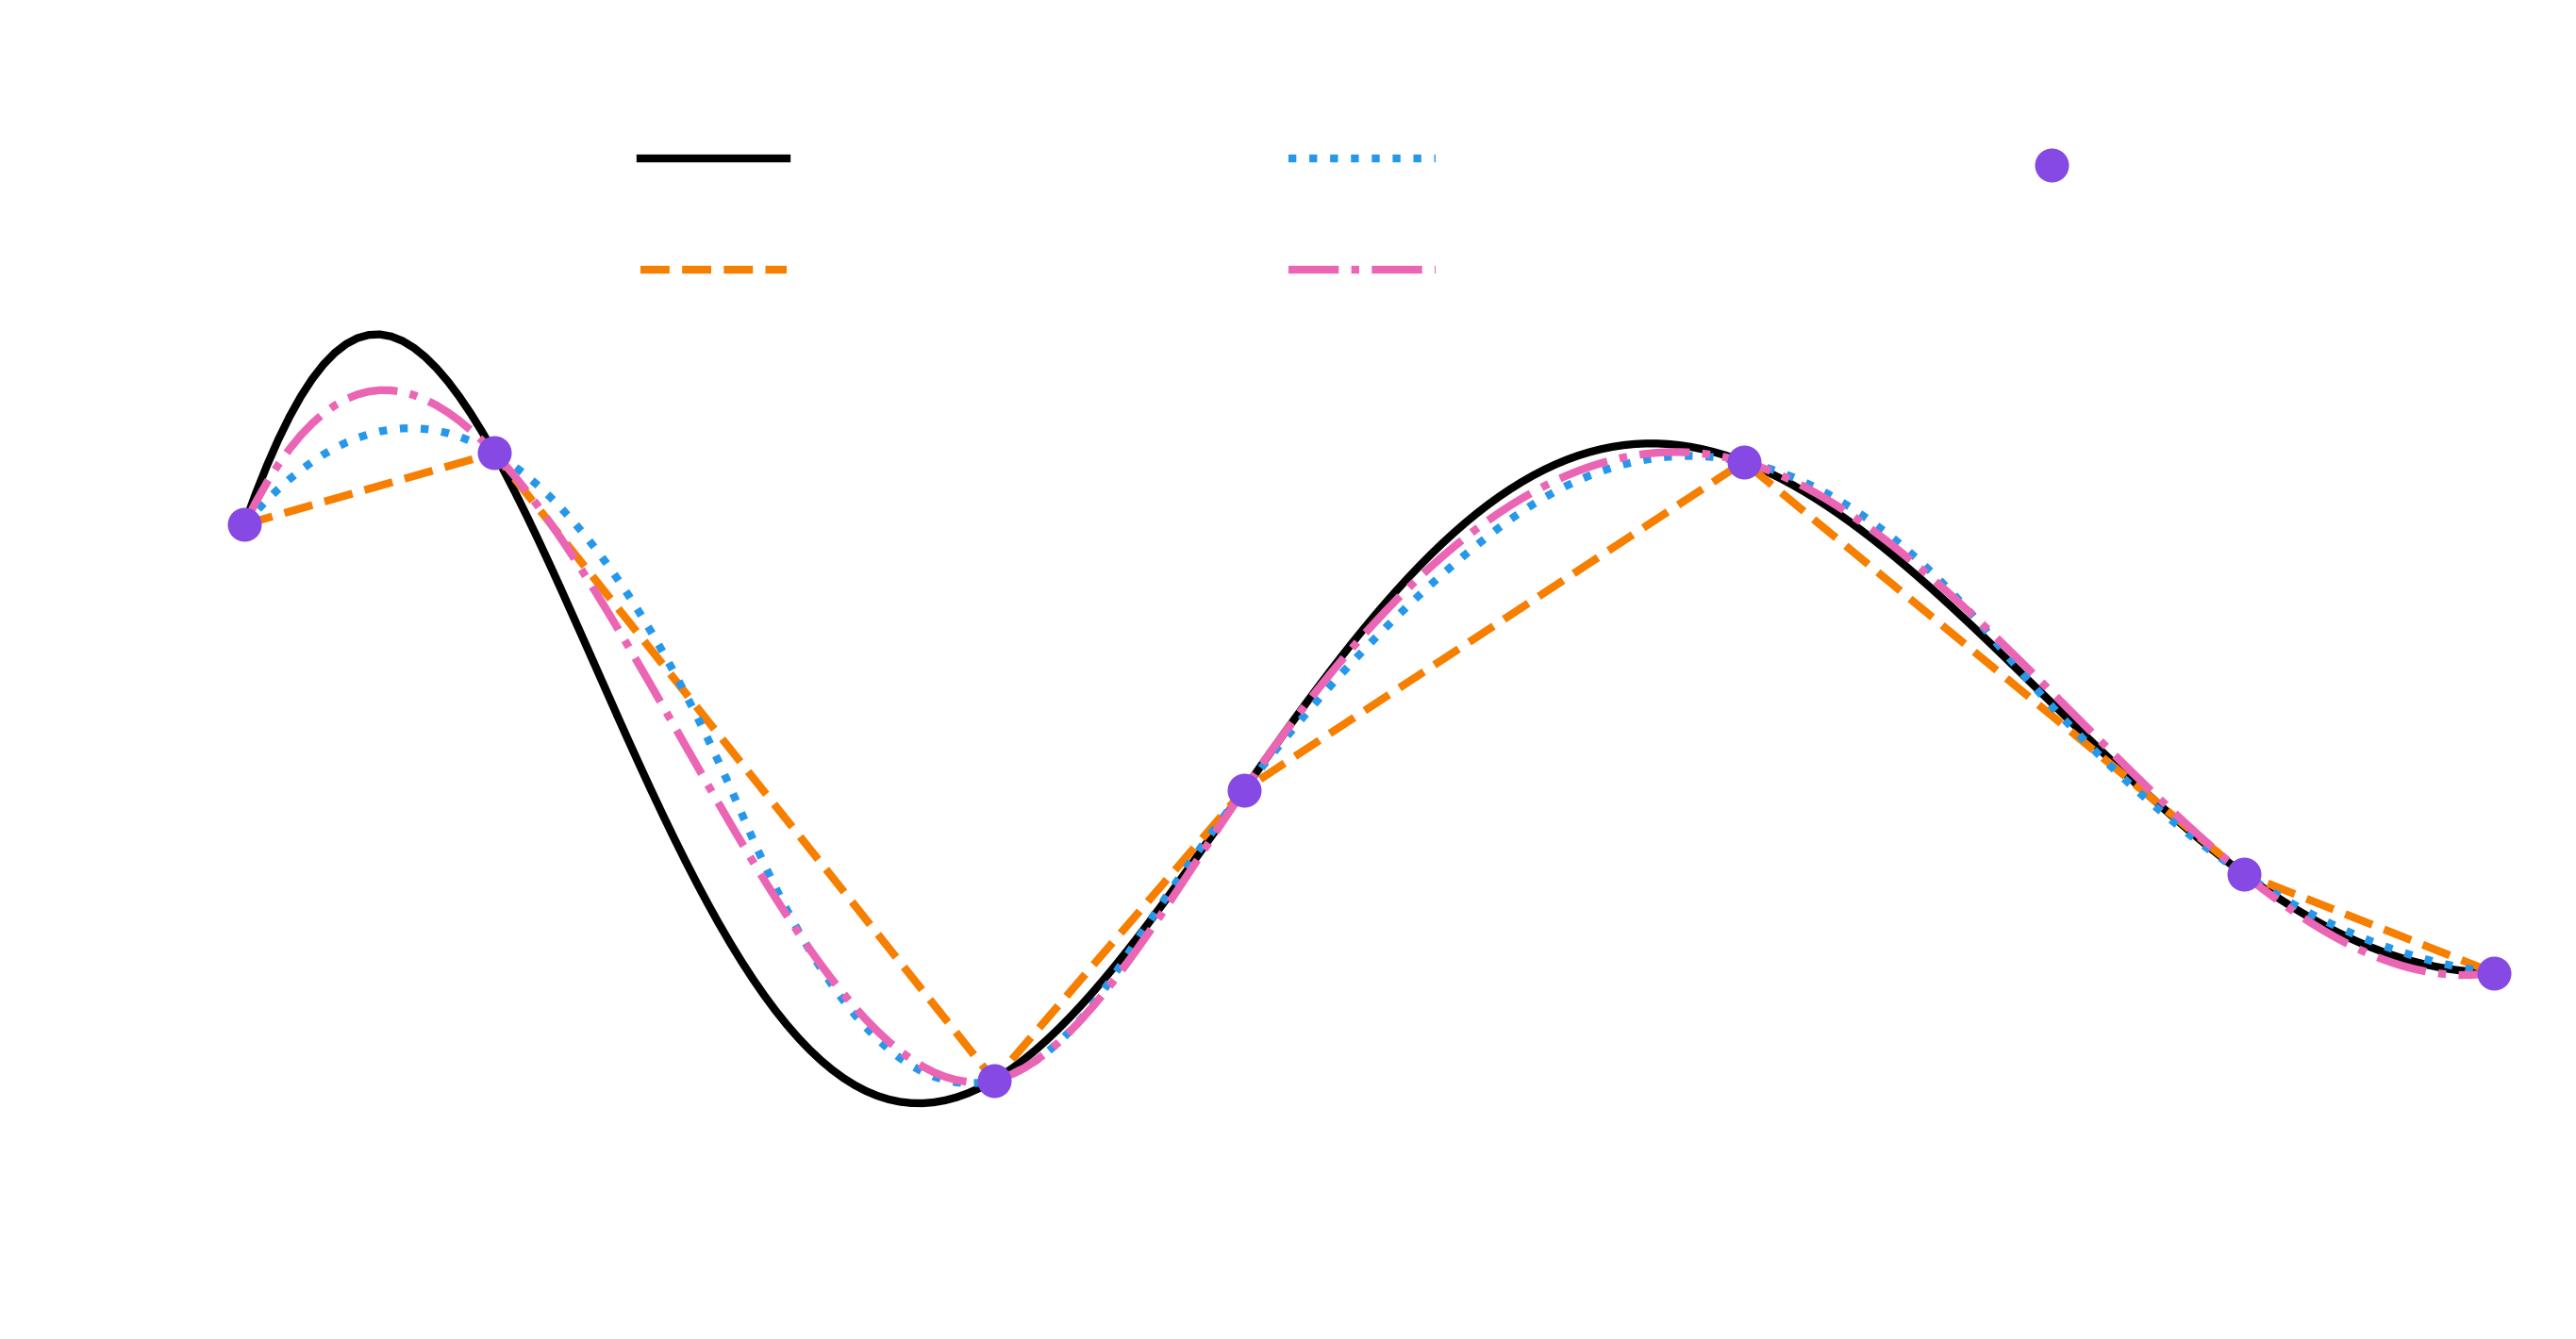

In [3]:
from scipy.interpolate import interp1d

y_linear = interp1d(xs, ys, kind="linear")(x_fine)
y_quad = interp1d(xs, ys, kind="quadratic")(x_fine)
y_cubic = interp1d(xs, ys, kind="cubic")(x_fine)

plt.scatter(xs, ys, s=30, zorder=20, label="Samples")
plt.plot(x_fine, y_fine, label="Function", color="k")
plt.plot(x_fine, y_linear, label="Linear")
plt.plot(x_fine, y_quad, label="Quadratic")
plt.plot(x_fine, y_cubic, label="Cubic")
plt.legend(ncol=3);
plt.ylim(3.4, 5.5); ###REMOVE

Well, obviously linear isn't a good fit. Quadratic and cubic dont look too bad, but there's no uncertainty on our interpolated values, so its hard for us to know how good (accurate) our interpolation is at any point along the x-axis.

## Covariance matrices?

Let's now completely change topics. You'll see why soon. Let's create a highly correlated covariance matrix. If this is new terminology for you, a covariance matrix describes the uncertainty on your data, and how the uncertainty on one point is related to the uncertainty on another point. If you have data points which are completely independent, the matrix is just a diagonal line (off-diagonal elements are zero). But if two data points right next to each other are related, then the cell corresponding to that pair won't be zero.

I digress, here's a covariance matrix which has values that decay as you move away from the diagonal:

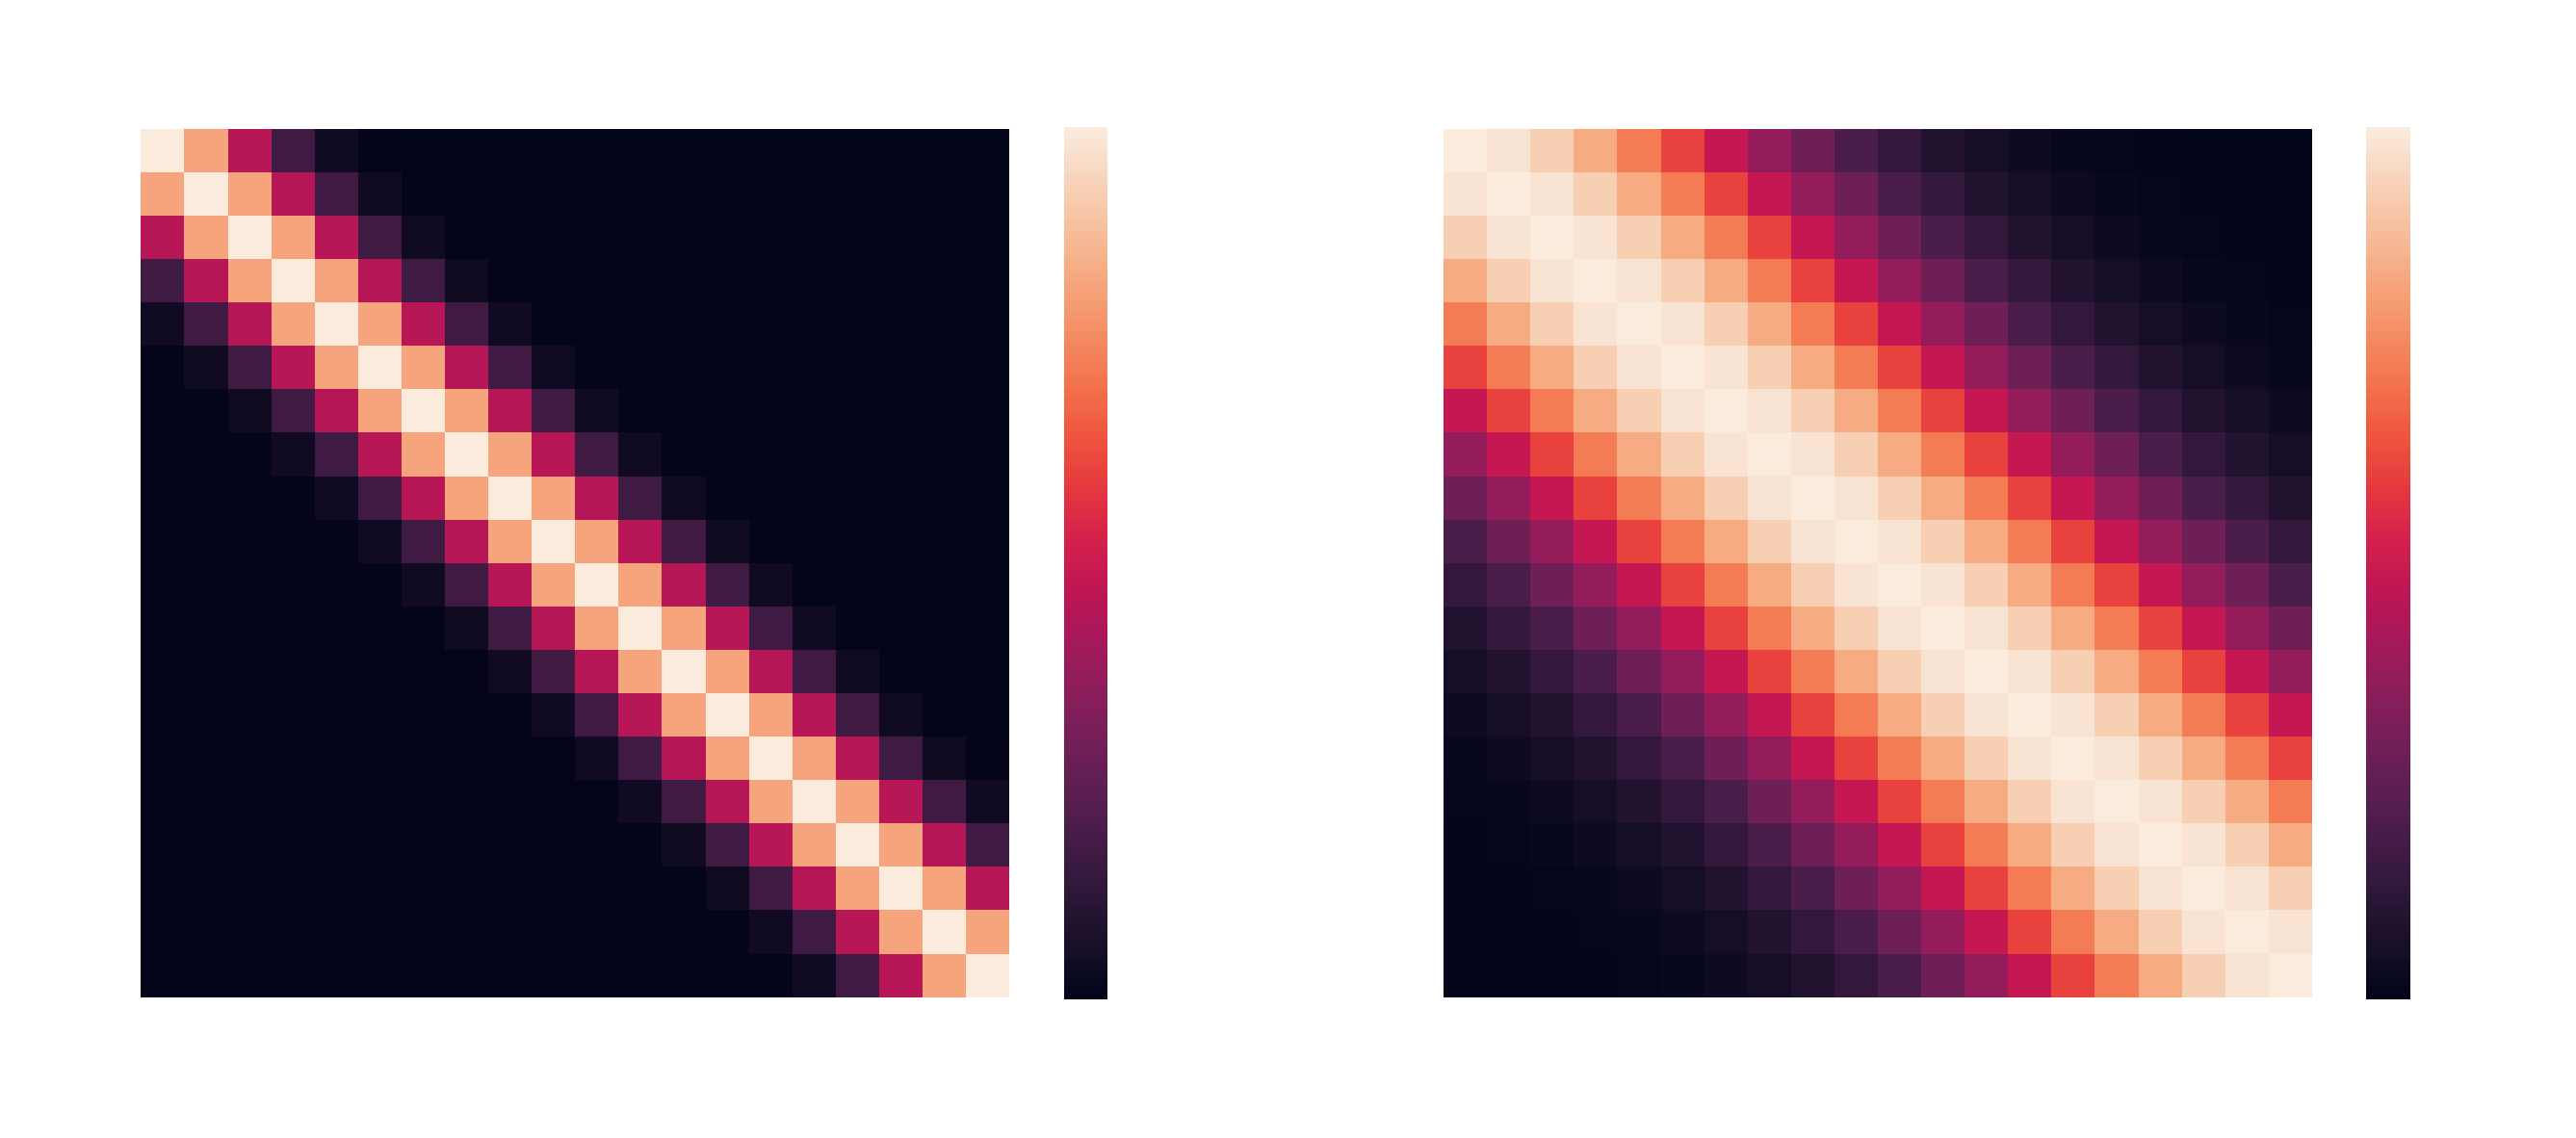

In [12]:
import seaborn as sb

def get_cov(size=20, length=50):    
    x = np.arange(size)
    cov = np.exp(-(1 / length) * (x - np.atleast_2d(x).T)**2)
    return cov

cov = get_cov()
cov2 = get_cov(length=5)

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
axes[0].set_title("Small correlation length", fontsize=14)
axes[1].set_title("Large correlation length", fontsize=14)
sb.heatmap(cov2, ax=axes[0], square=True)
sb.heatmap(cov, ax=axes[1], square=True);

To try and illustrate what covariance does, we can actually use `scipy` to generate data *according* to that covariance matrix. By tweaking the `length` argument, you can see that the longer the correlation length, the smoother the generated data trend becomes:

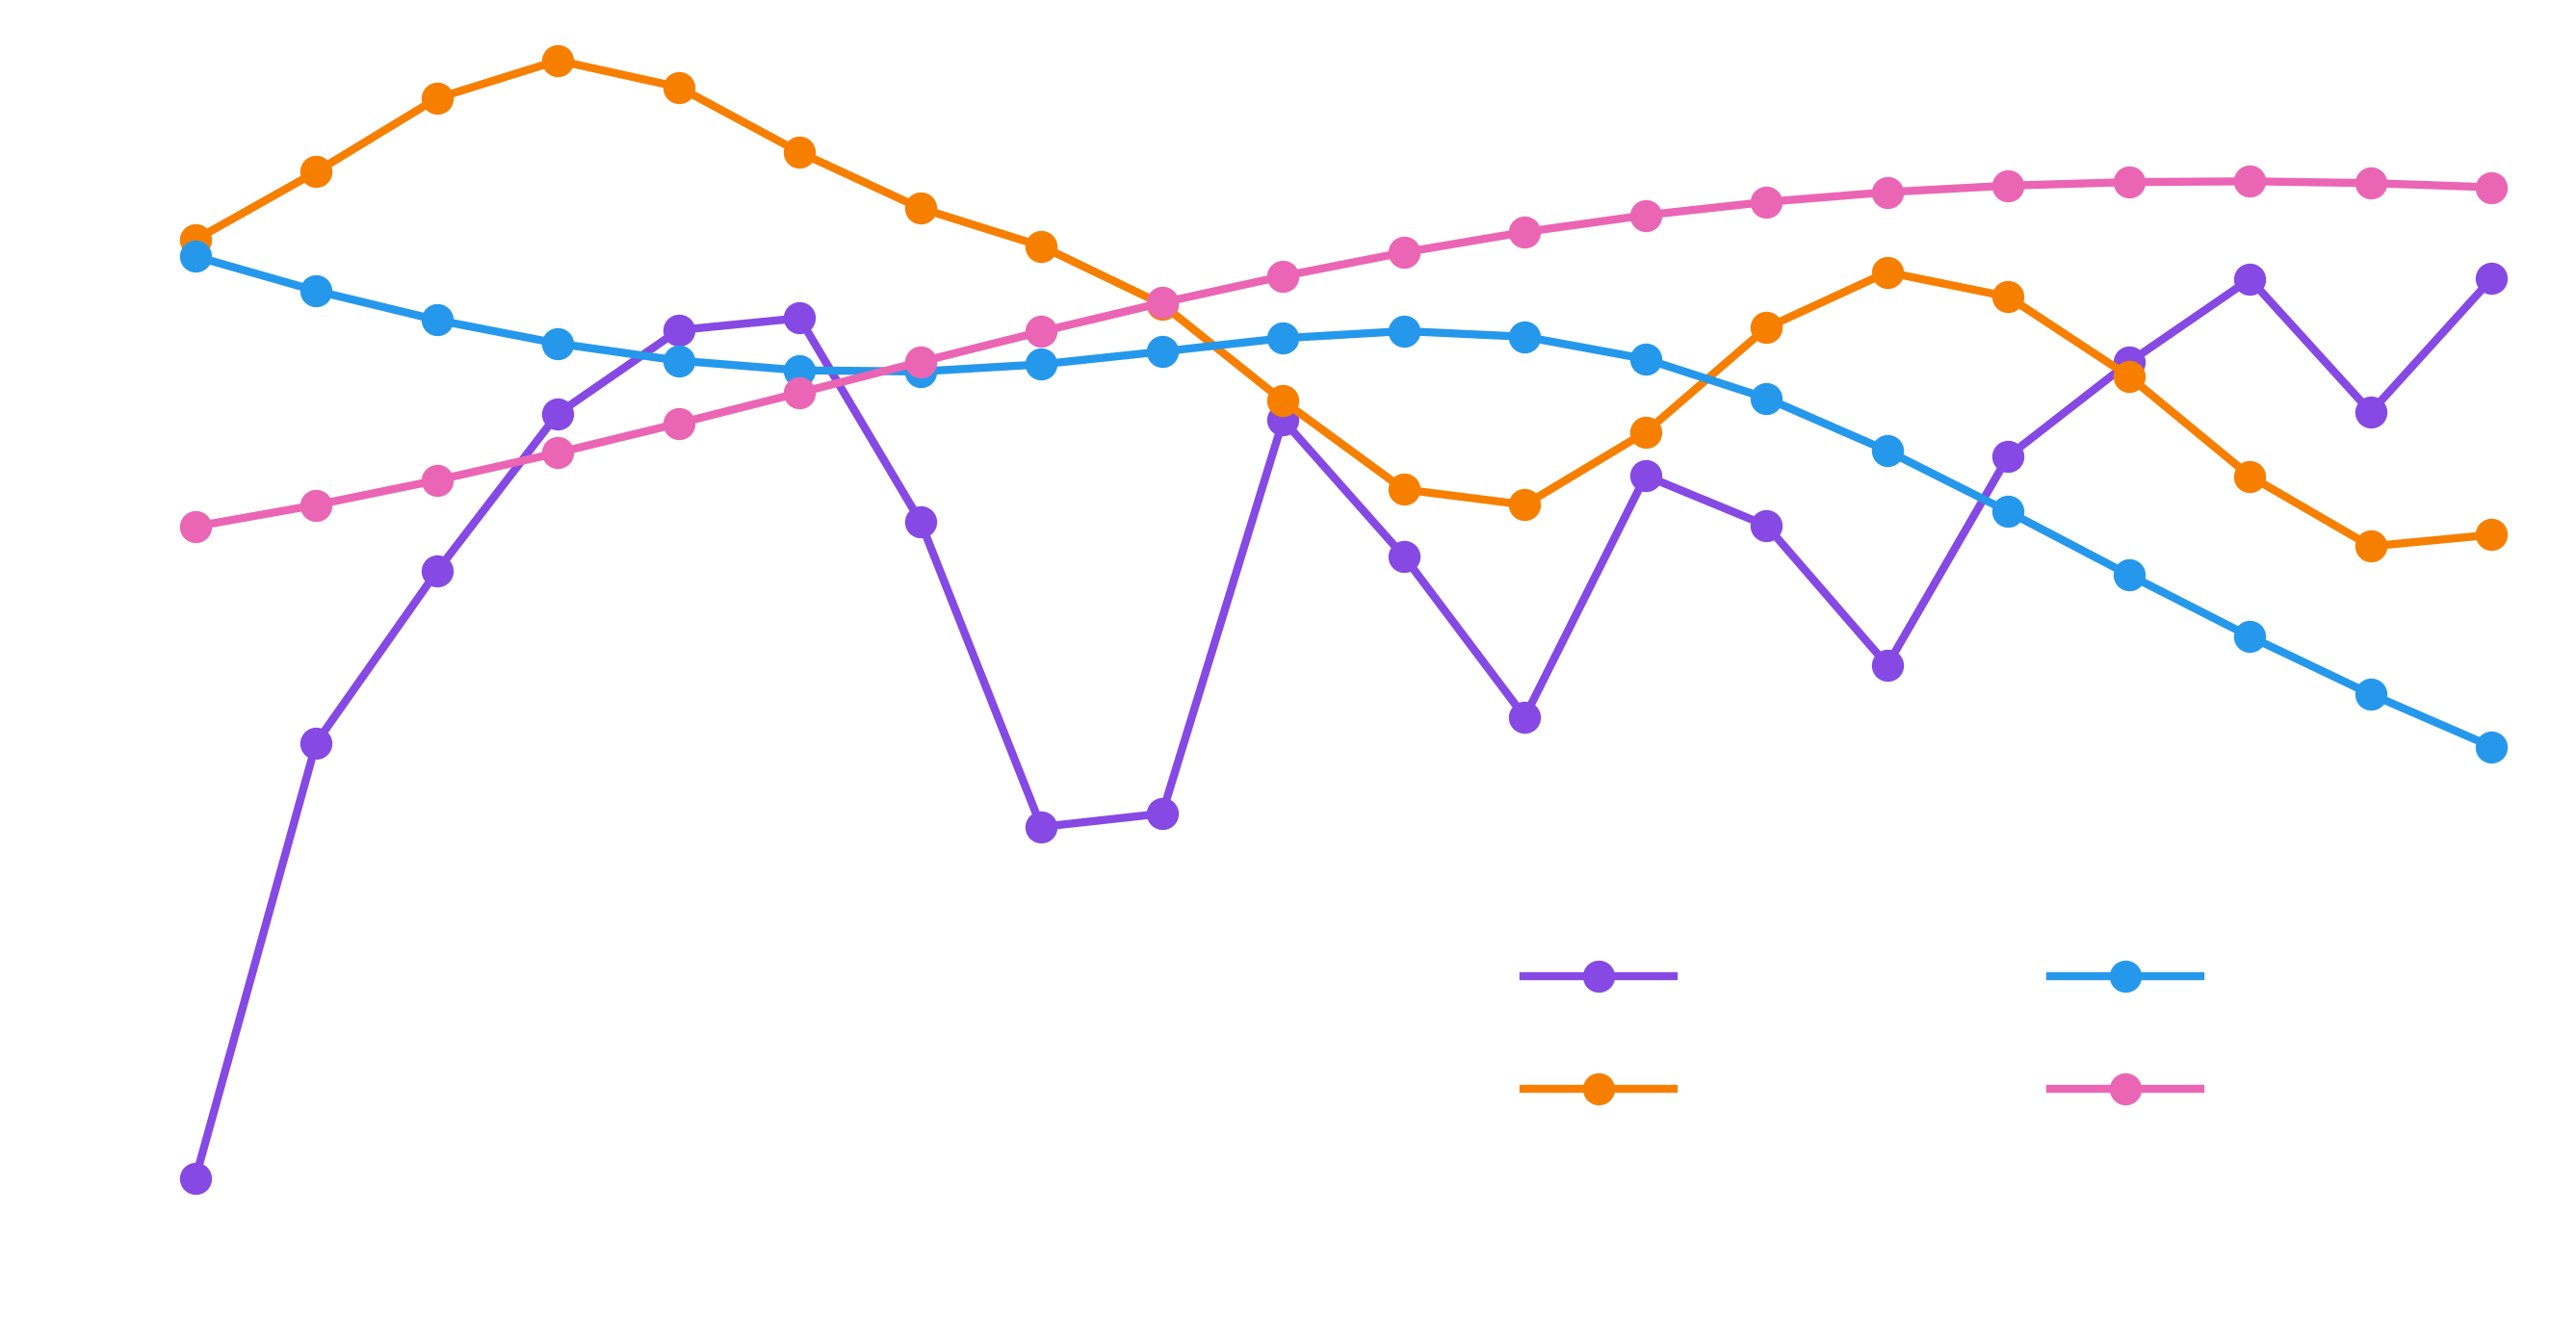

In [13]:
from scipy.stats import multivariate_normal as mn
x = np.arange(20)
np.random.seed(1) ###REMOVE
for l in [1, 10, 50, 200]:
    cov = get_cov(length=l)
    rvs = mn.rvs(cov=cov)
    plt.plot(x, rvs, 'o-', ms=5, label=f"L={l}")
plt.legend(ncol=2);

The take away from this is simply that increasing correlation length means you can generate smooth transitions rather than jagged, uncorrelated data. This correlation length is one of the pieces of the puzzle when creating a Gaussian process.

Let's say that you have a fixed start and end point you want to interpolate between. Linear interpolation will just draw a straight line. But we can use the magic of drawing correlated data to produce some uncertainty on our interpolation. (The unspoken piece here is that we have to determine the right correlation value when training a Gaussian process. We'll do that in a tick.)

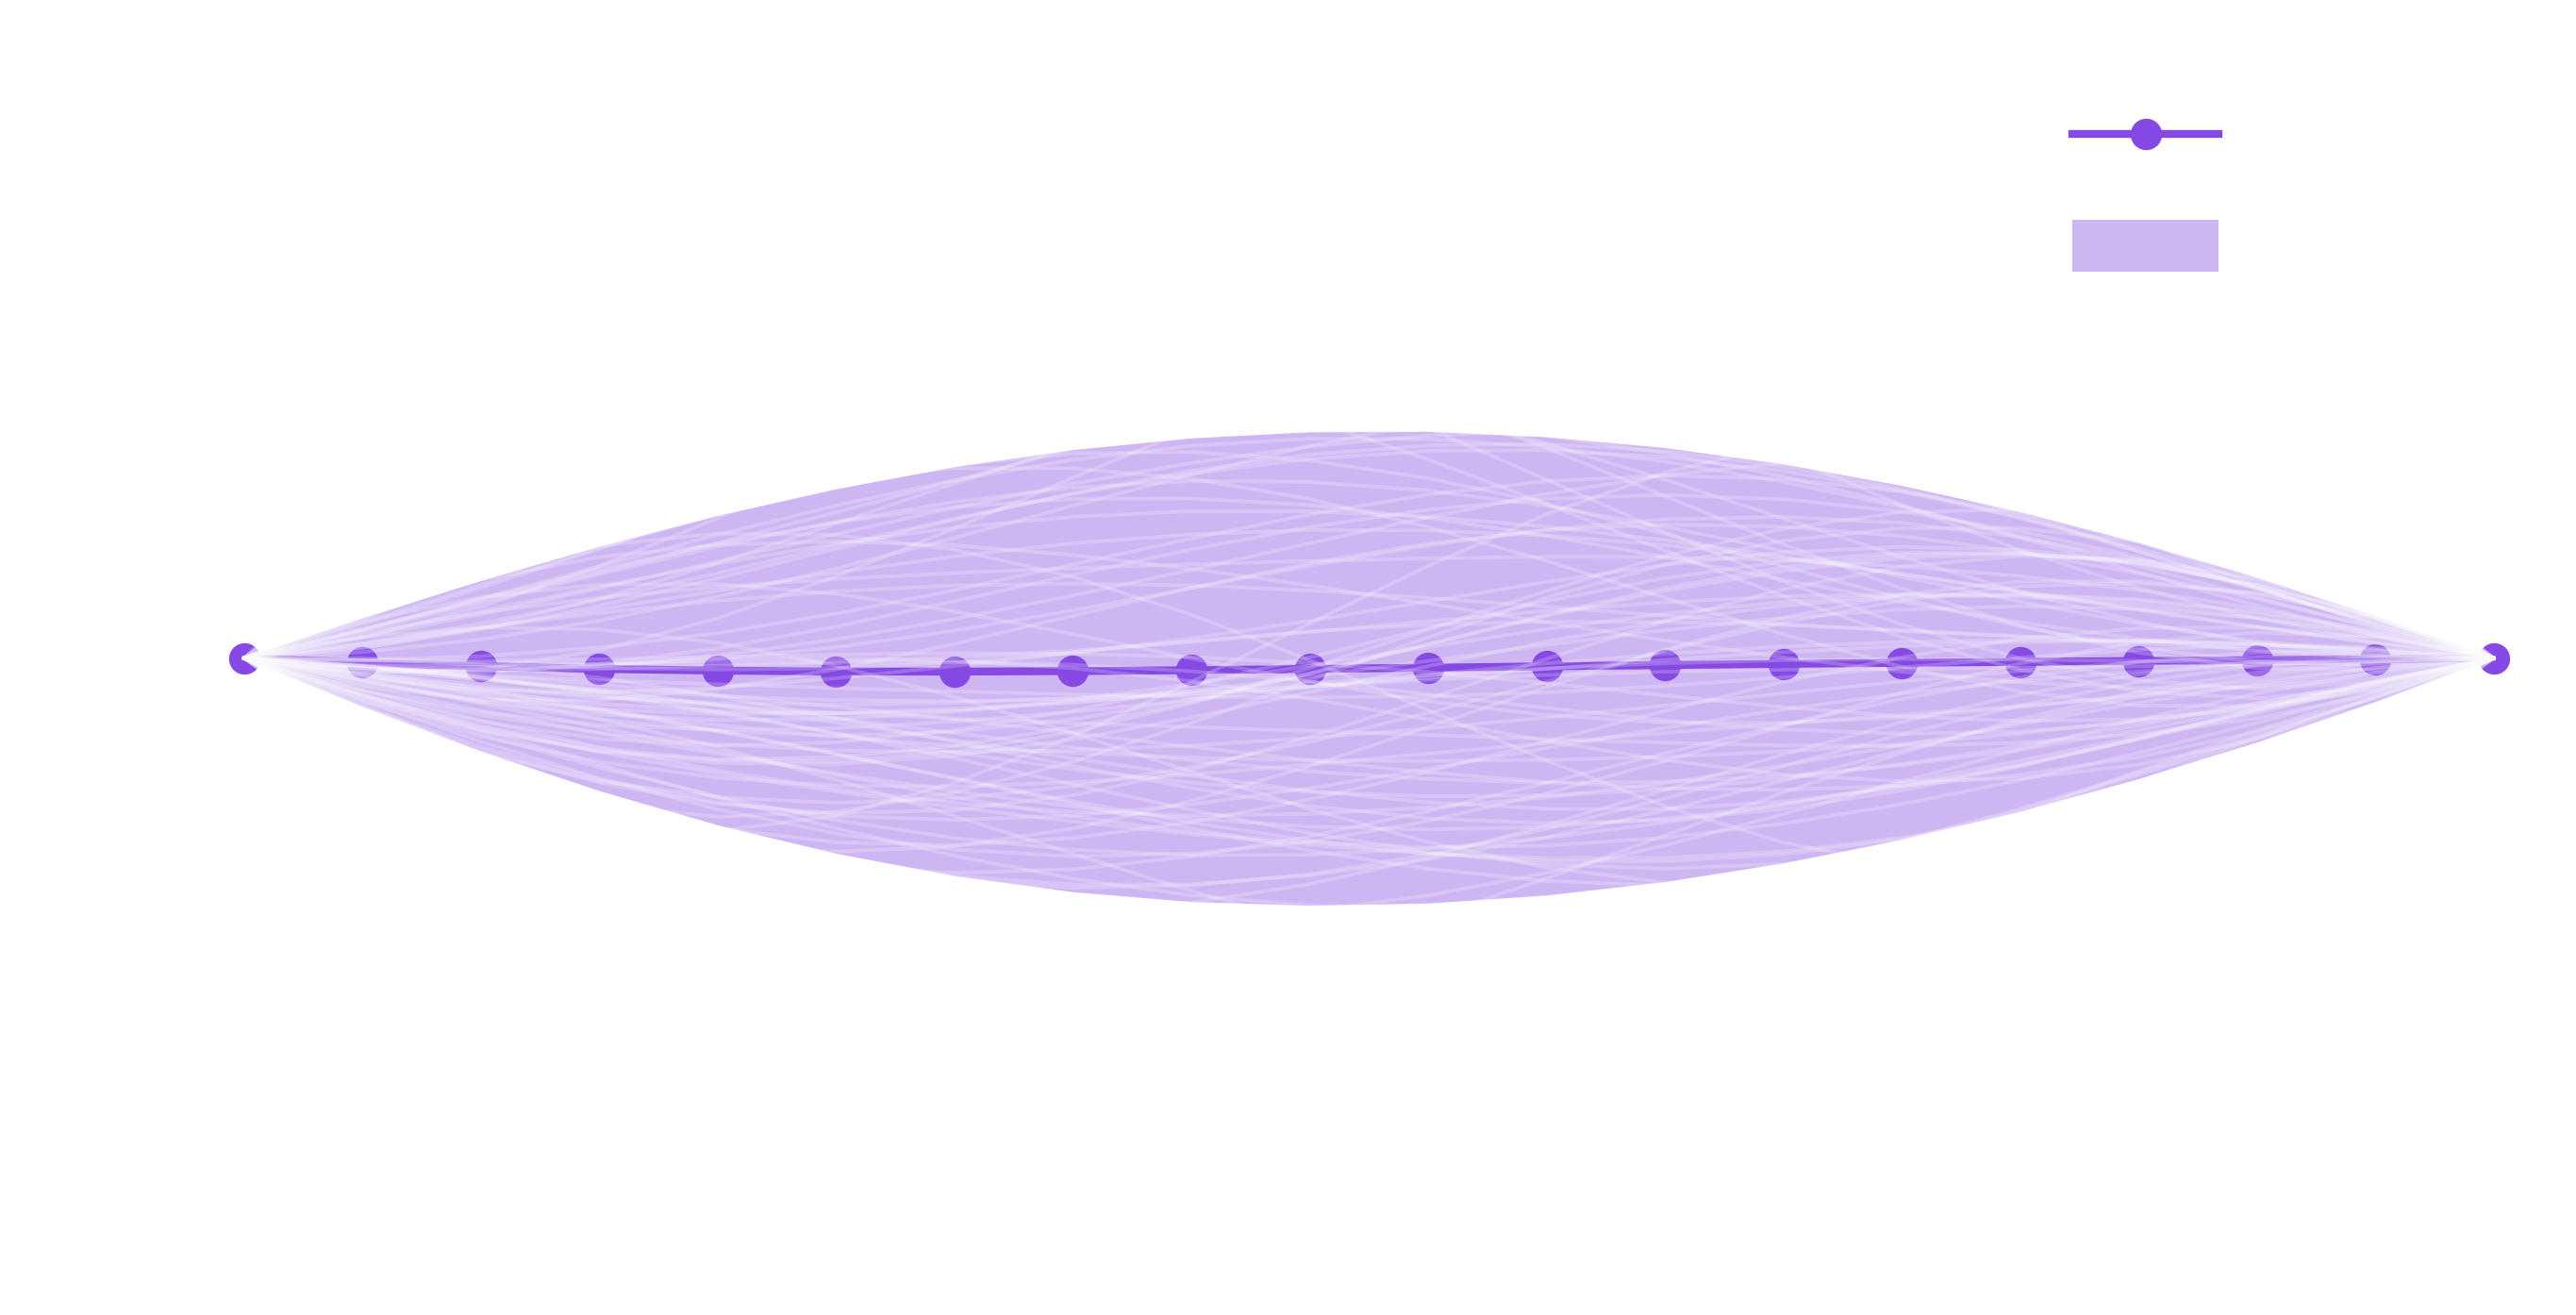

In [15]:
# In the previous code, we made one set of points four times in a loop
# Here, we generate 500 sets of our data points in one go
rvs = mn.rvs(cov=cov, size=500)

# Set the start and end points the same for all realisations
rvs -= np.linspace(rvs[:, 0], rvs[:, -1], x.size).T

# Get the mean and std of our 500 realisations
mean = rvs.mean(axis=0)
std = np.std(rvs, axis=0)

# Plot the mean and std
plt.plot(x, mean, "o-", ms=5, label="mean")
plt.fill_between(x, mean + std, mean - std, alpha=0.4, label="std")

# And for fun, lets plot 100 of the data realisations
for i in range(100):
    plt.plot(x, rvs[i, :], ls="-", c="w", alpha=0.2, lw=0.7)
plt.legend();

What we've done is effectively interpolated between these two points using some covariance matrix, and that covariance matrix has allowed us to produce not just the interpolation, but an uncertainty on it as well (shown by the mean and std above). The small black lines are showing independent "realisations" of the random draws, the ensemble of which determine the mean and standard deviation of our output prediction.

The keen eyed among you will have seen some form of problem - we have 20 points in the x-axis here, and our covariance matrix we generated before is a 20x20 matrix. There are infinite real numbers between 0 and 20, so how on earth will we construct an infinite matrix to do this in practise? This is in fact entirely what the "non-parametric" part of Gaussian Processes refers to. Not that there are no parameters, but that there are an infinite/arbitrary number of them. 

To try and hammer this part home, by drawing over and over we can come up with some mean prediction and some standard deviation on it. This is dependent on our choice for covariance. The covariance we have used has only one parameter, its length scale. The larger $l$ gets the smoother and less changing the predictions become. This number that we 'pick' is a model parameter - it's something we fit when creating a real GP.

And in terms of nomenclature, moving from a multivariate Gaussian to a Gaussian process means we move from having a mean to having a mean function (because we can ask for the mean at any x). Similarly the covariance matrix depends on the input data points (in our previous example we didnt have any, just hack fixed the first and last point) and the points we want to evaluate at, so we have a covariance function. The shape of the covariance (ie we had squared distance if you look at the `get_cov` function) is called the kernel (you can have different functions, squared distance is just a useful one).

# Gaussian Processes

Hopefully the above is enough of an introduction to covariance and correlated draws. Gaussian processes work by training a model, which is fitting the parameters of the specific kernel that you provide.  The difficulty is in knowing what kernel to construct and then let the model train. This kernel essentially relates how every data point affects regions in parameter space.

All this kernel says is that if you are interpolating at point x, which lies between point A and point B, you determine how much A contributes and then do the same for B (plus all other points too). This is another important concept - in normal interpolation, only A and B would affect your result if you ask for a point between A and B. In a Gaussian Process, every point affects you!

So lets start with a super simple kernel function - the exponential falloff with distance we did ourselves before. This is implemented in `scikit-learn` as RBF (Radial Basis Function). The training part of this is to find the best value of the length scale in the kernel that gives the best results.

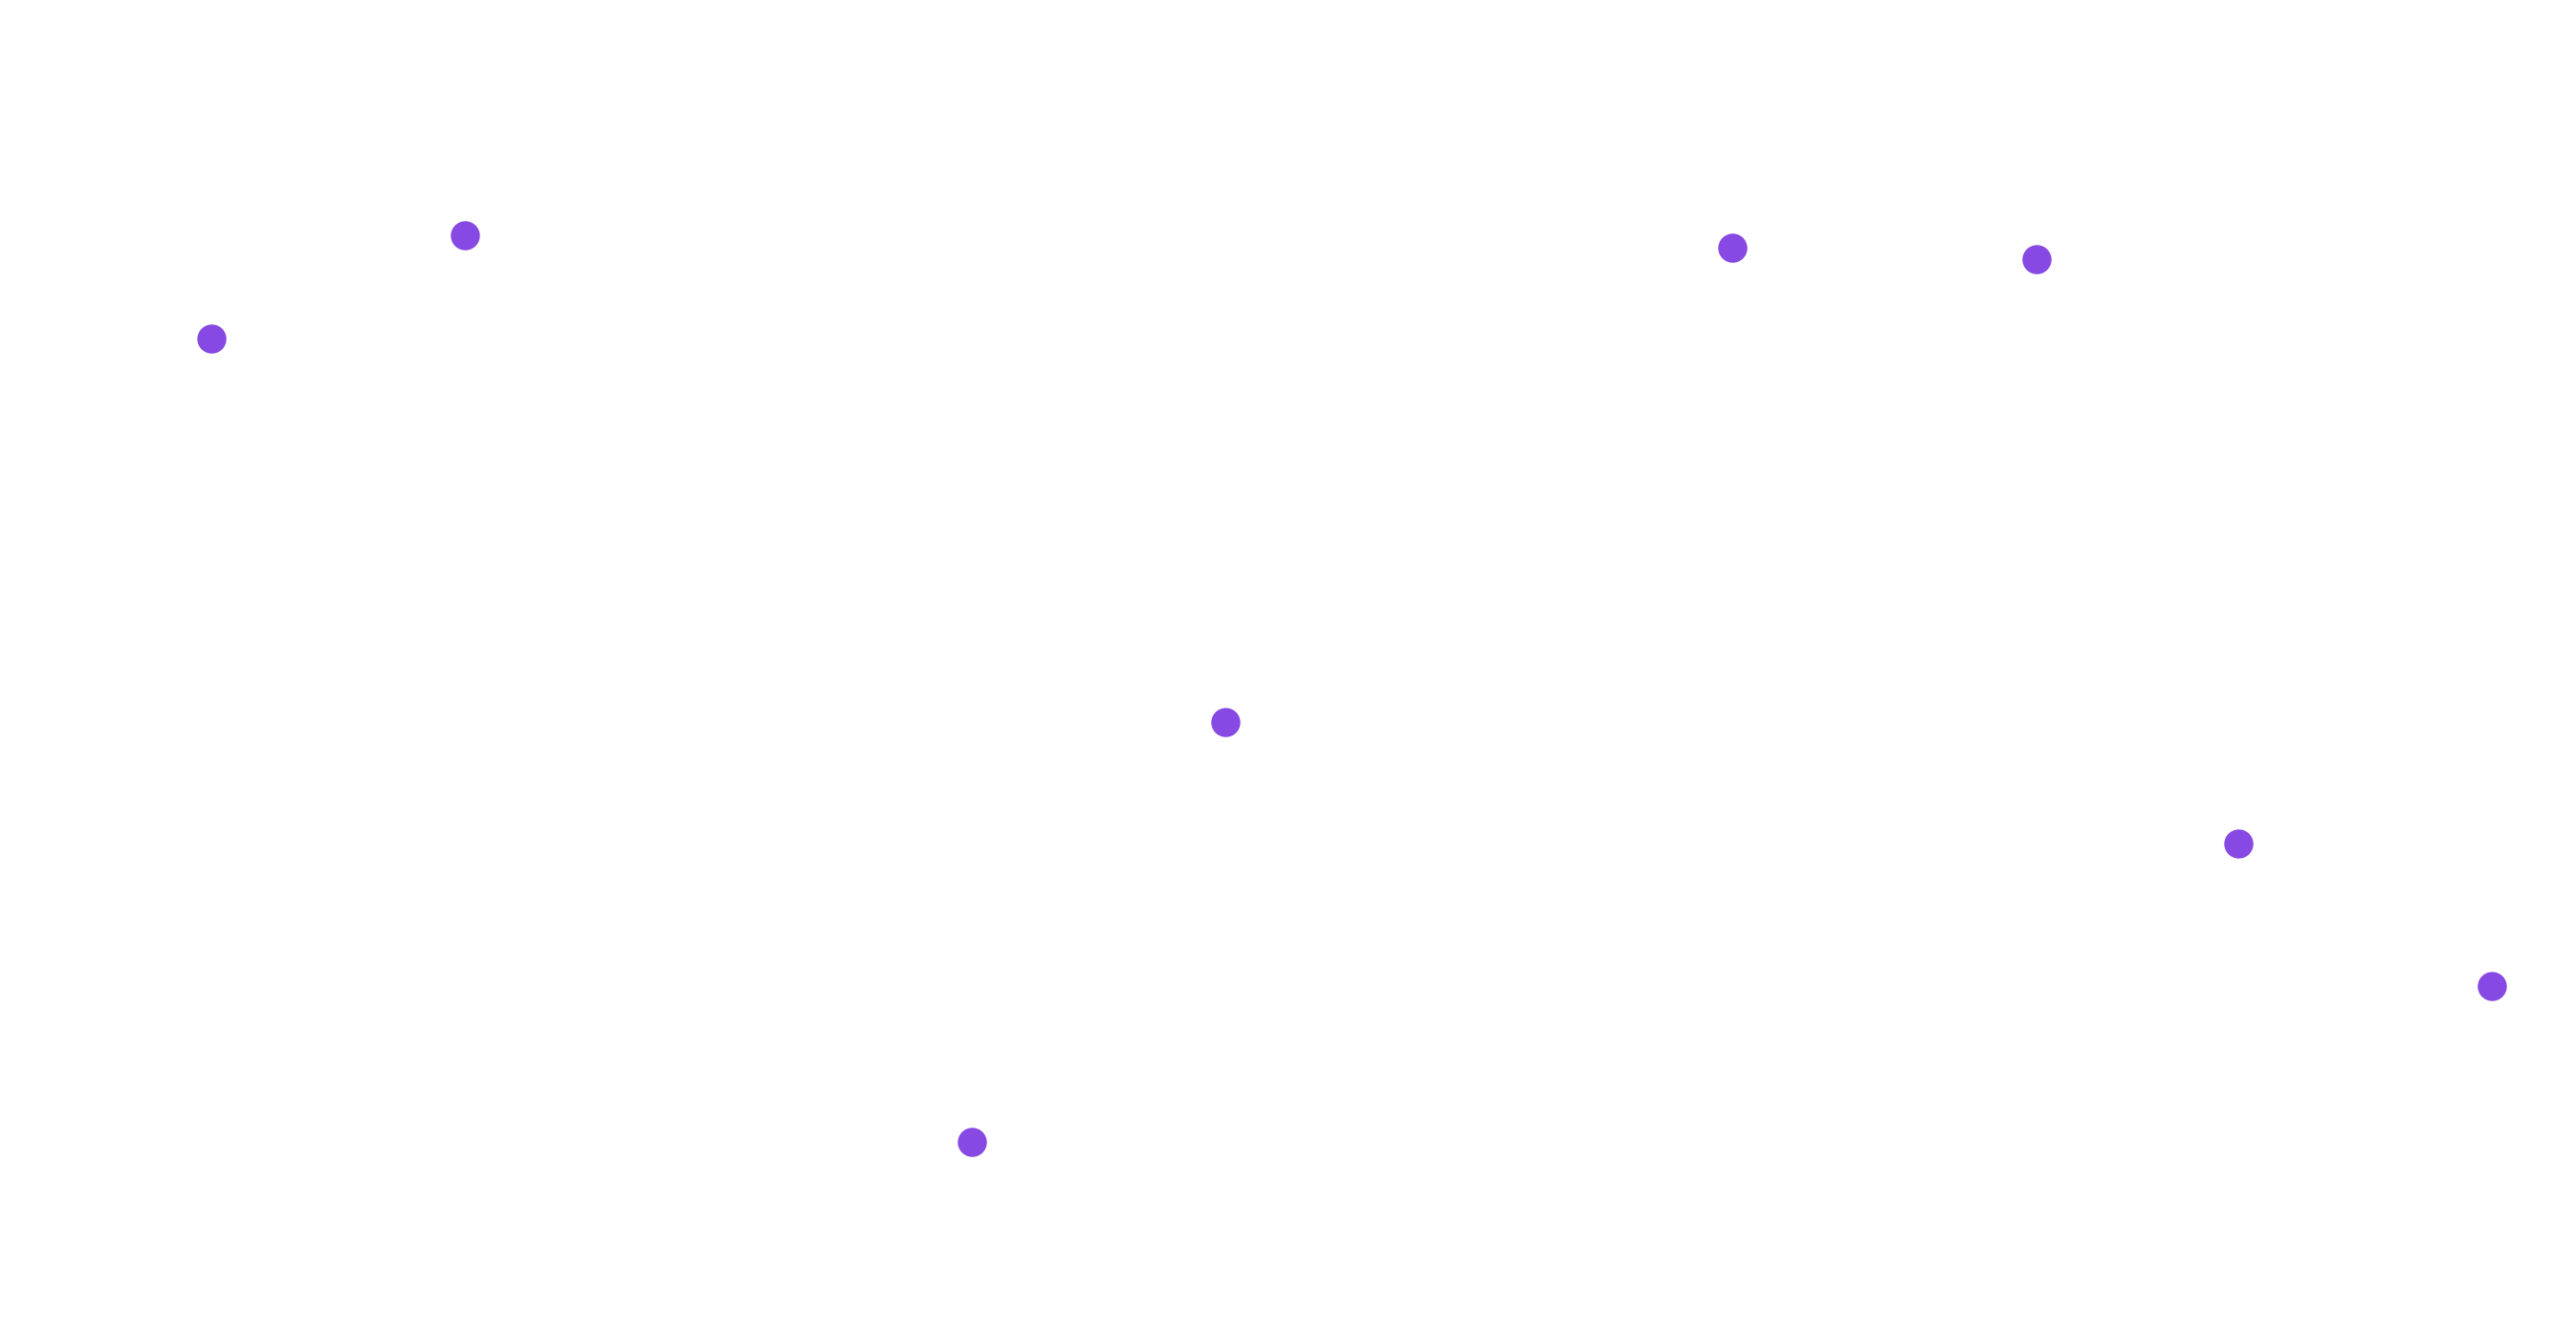

In [16]:
# To refresh your mind on our data
plt.scatter(xs, ys, s=20, label="Samples", zorder=30)
plt.plot(x_fine, y_fine, label="Function", color="w")
plt.legend();

And now to utilise the Gaussian process from sklearn. Let's make 3 different models.

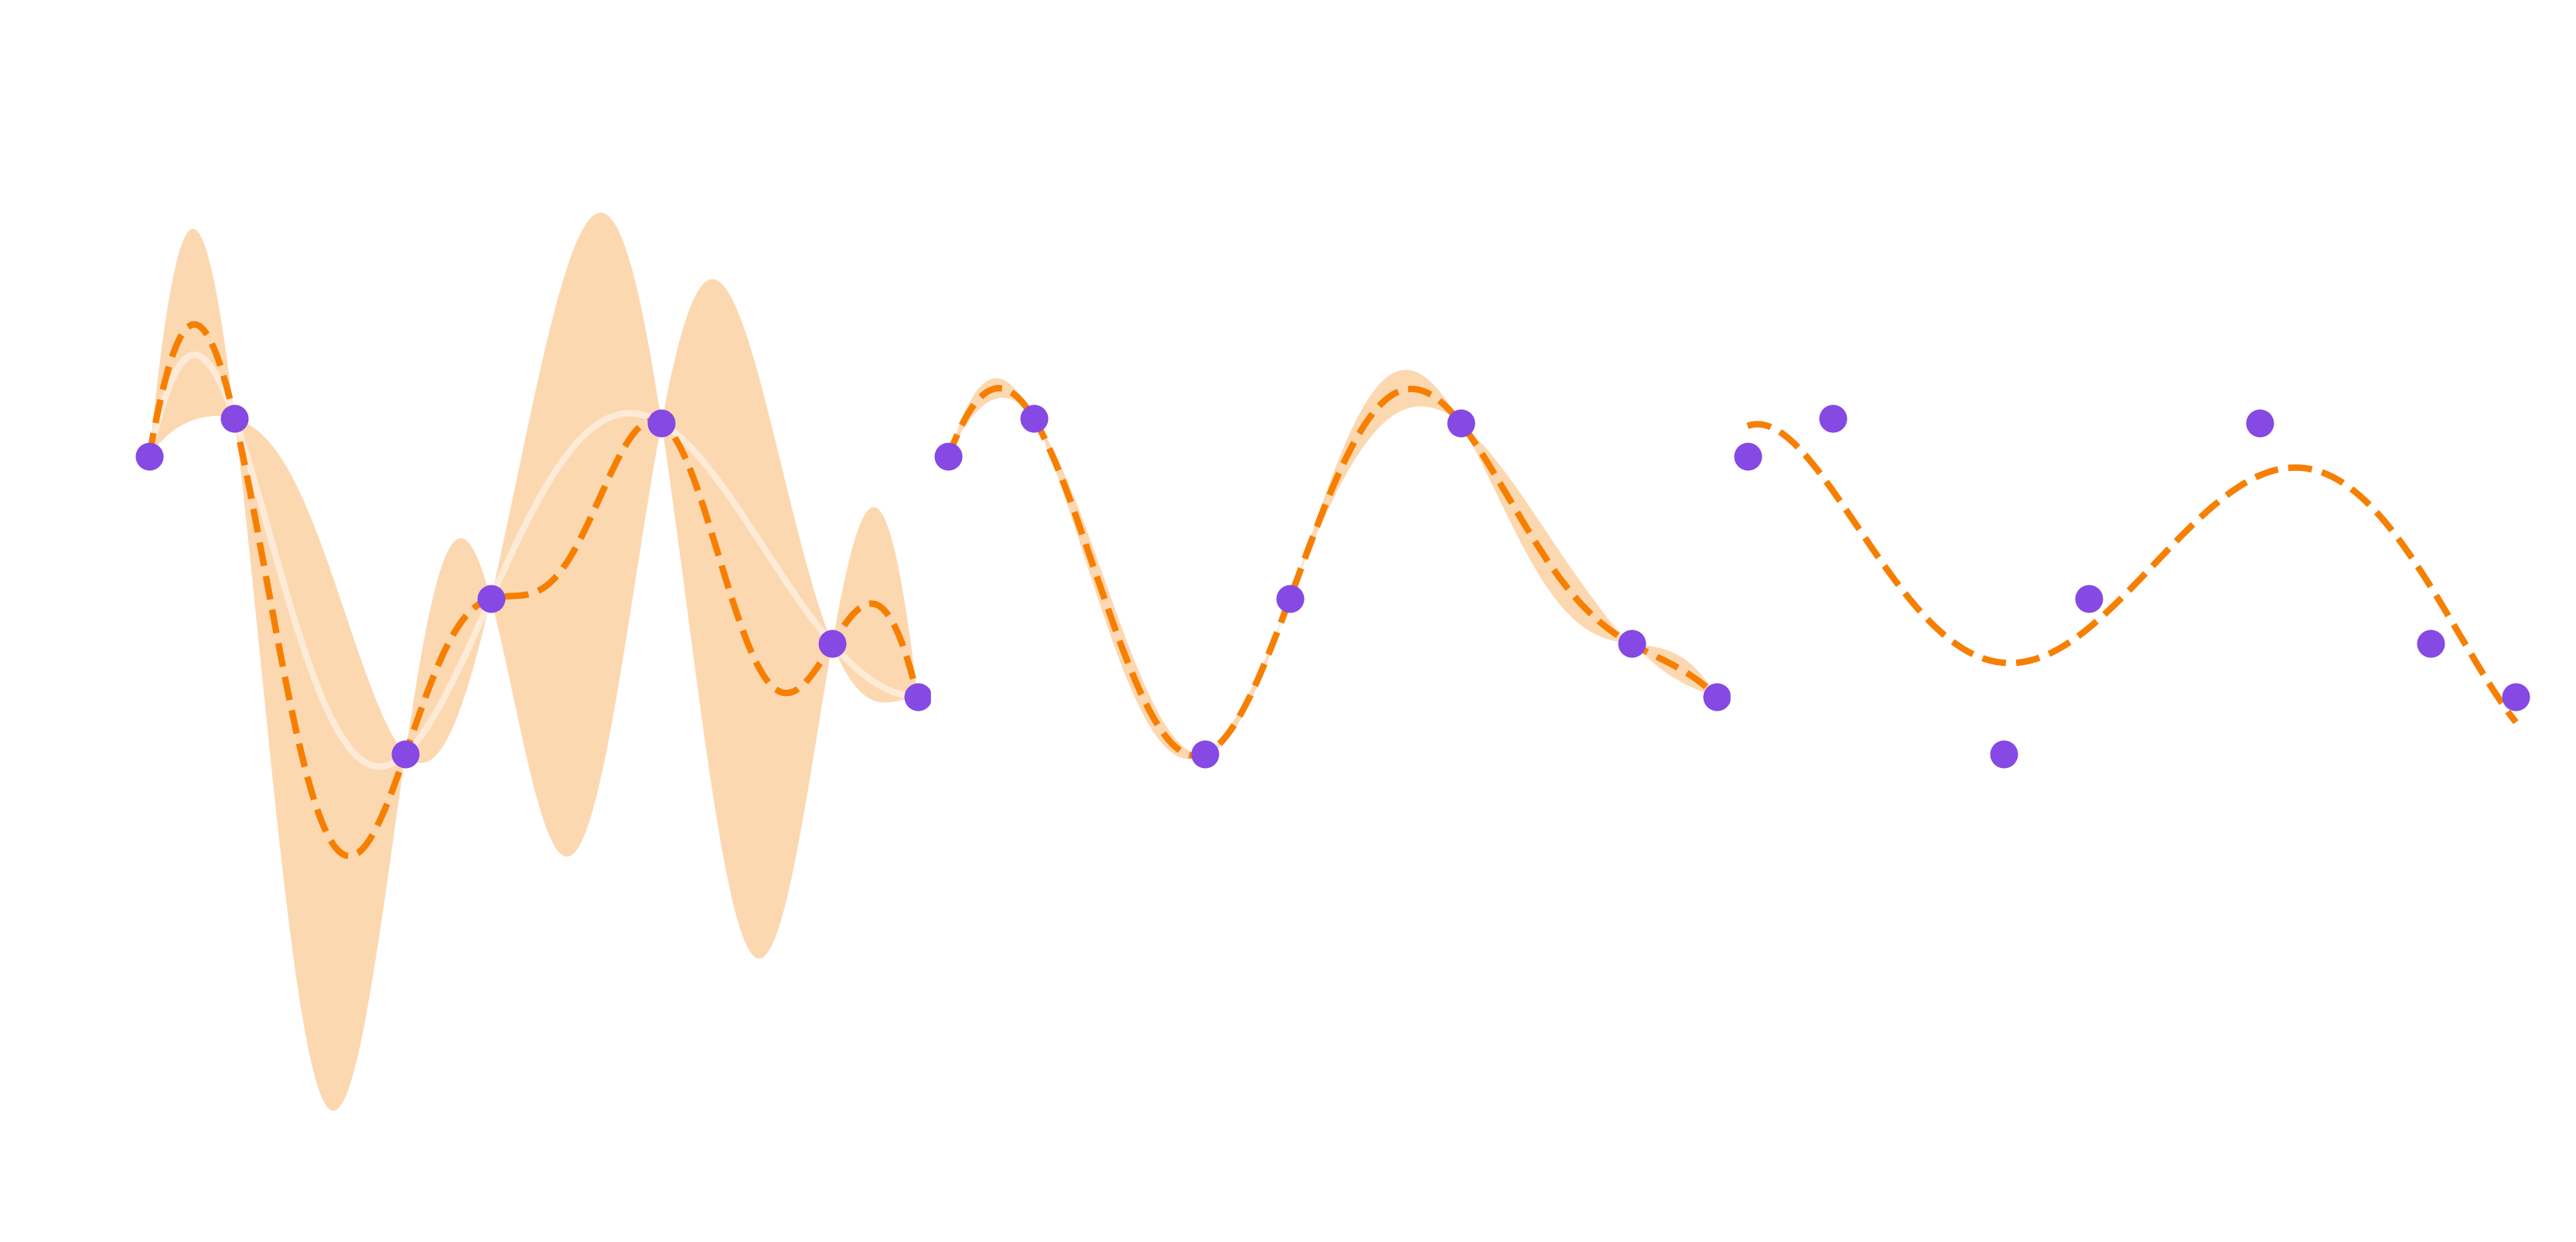

In [18]:
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
# Note I am NOT training these models. You can see in the bounds
# I am forcing them to have specific lengths. Normally, they would 
# fit to your data
kernels = [
    k.RBF(length_scale=1.0, length_scale_bounds=(1.0, 1.01)), 
    k.RBF(length_scale=2.0, length_scale_bounds=(2.0, 2.01)),
    k.RBF(length_scale=20.0, length_scale_bounds=(20.0, 20.01)),
]

# Make some axes please
fig, axes = plt.subplots(figsize=(10, 4), ncols=len(kernels), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for kernel, ax in zip(kernels, axes):
    # Fit the GP, which doesnt do much as we fixed the length_scale
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(np.atleast_2d(xs).T, ys)
    
    # The 2D and [:, None] stuff is because the object expects 2D data in, not 1D
    y_mean, y_std = gp.predict(x_fine[:, None], return_std=True)

    ax.scatter(xs, ys, s=30, label="Samples", zorder=20)
    ax.plot(x_fine, y_fine, label="Function", color="w", alpha=0.5)
    ax.plot(x_fine, y_mean)
    ax.fill_between(x_fine, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.3)
    ax.set_title(f"{kernel}\n{y_std.max():0.4f}")

You can see on the left we have a model where the length scale is too small - our uncertainty is huge between points. On the right the length scale is so large its pulling even the known data points away from where they belond (as the length scale gets larger, the line would start to flatten out and look like the mean of all data points). But the middle looks pretty good.

If we want to fit the hyperparameters, what we do is maximise the marginal likelihood, conditioned on the hyperparameters. I won't go into the math, but the marginal likelihood has a term for how well it fits to data (so the right hand plot would have a horrible score), a normalisation term, and a penalty for complexity (so the left hand model would be too complex because its scale is too small and allows for too much freedom).

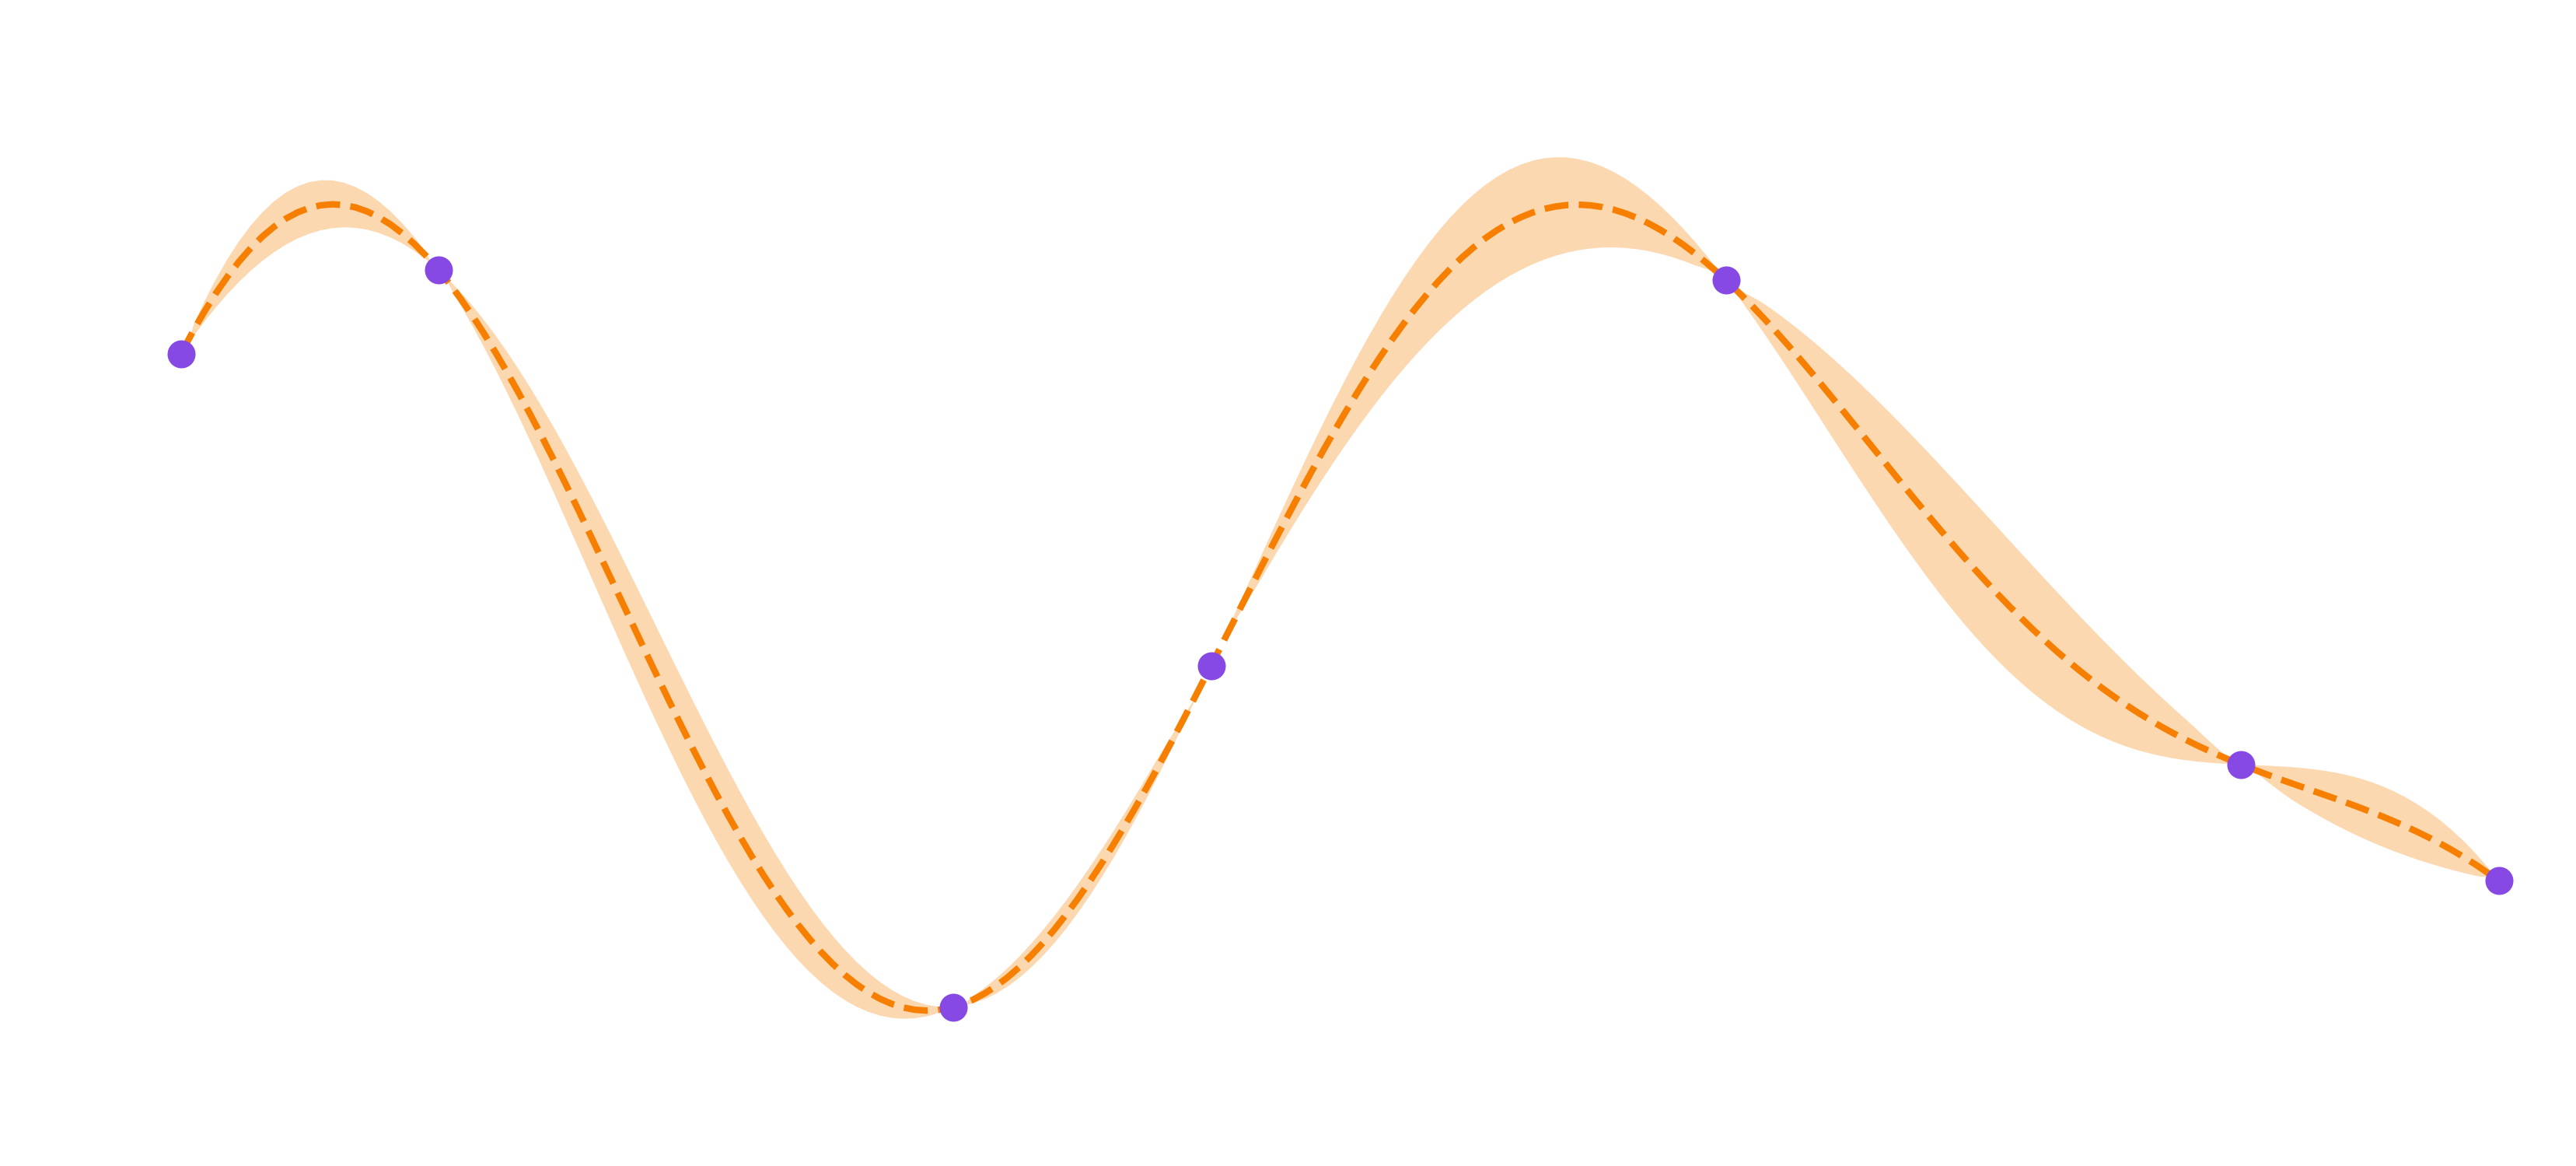

In [19]:
# Start at 2.0, fit a value between 1 and 10
kernel = k.RBF(length_scale=2.0, length_scale_bounds=(1.0, 10.0))
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(np.atleast_2d(xs).T, ys)
y_mean, y_std = gp.predict(x_fine[:, None], return_std=True)

# Plot it all, yay
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(xs, ys, s=30, label="Samples", zorder=20)
ax.plot(x_fine, y_fine, label="Function", color="w")
ax.plot(x_fine, y_mean)
ax.fill_between(x_fine, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.3)
ax.set_title(f"RBF, length_scale={gp.kernel_.length_scale:0.3f}");
# Note that the fitted kernel is inside the GP, the original kernel won't be modified.

But this is only talking about how to train model parameters. There are a ton of different kernels you can pick from, and thats the actual hard task. If you use deep gaussian processes they can do that for you too, but thats well beyond this write up.

Because kernels are really just functions, you can do multiple them, add them, combine them in fun ways. For example:

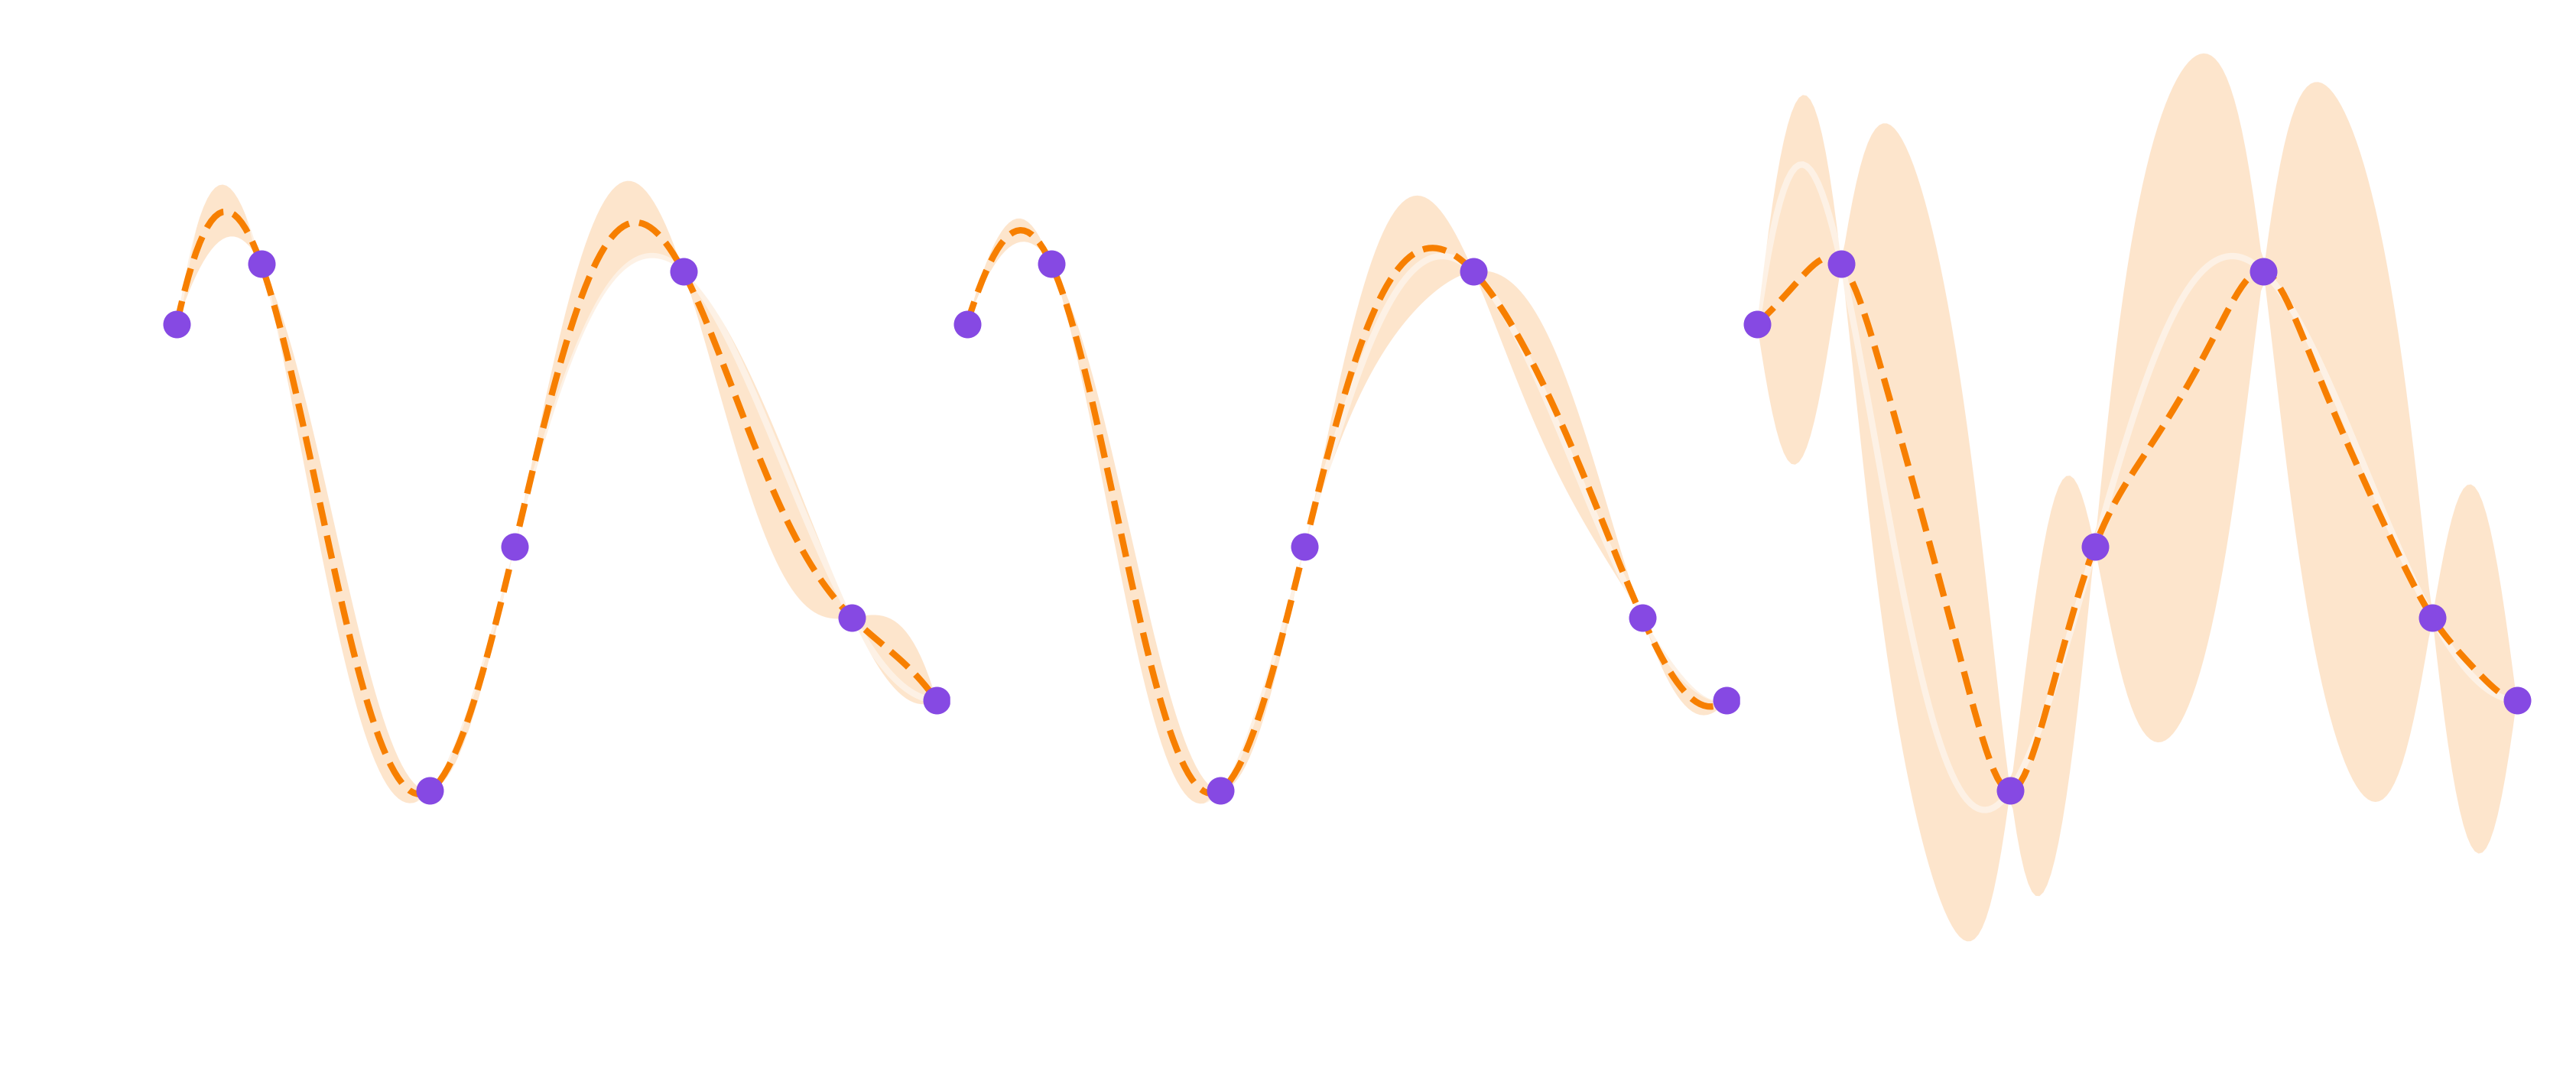

In [20]:
kernels = [
    k.ConstantKernel() * k.RBF(), 
    k.ExpSineSquared(periodicity=10),
    k.ConstantKernel() * k.RationalQuadratic() + k.RBF()
]

fig, axes = plt.subplots(figsize=(10, 4), ncols=len(kernels), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for kernel, ax in zip(kernels, axes):
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(np.atleast_2d(xs).T, ys)
    
    y_mean, y_std = gp.predict(x_fine[:, None], return_std=True)

    ax.scatter(xs, ys, s=30, label="Samples", zorder=20)
    ax.plot(x_fine, y_fine, label="Function", color="w", alpha=0.5)
    ax.plot(x_fine, y_mean)
    ax.fill_between(x_fine, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.2)


As you can see, picking the different kernels will have a huge impact on your fits. Its important to use some domain knowledge to help you pick. Looking at weather patterns over multiple years? Maybe a periodic kernel with a yearly frequency would be good to include, with a Constant * RBF added on to add some flexibility on short timescales? We now enter the domain of art.

But if you need something that works pretty well in general, a constant kernel and RBF can be combined easily:

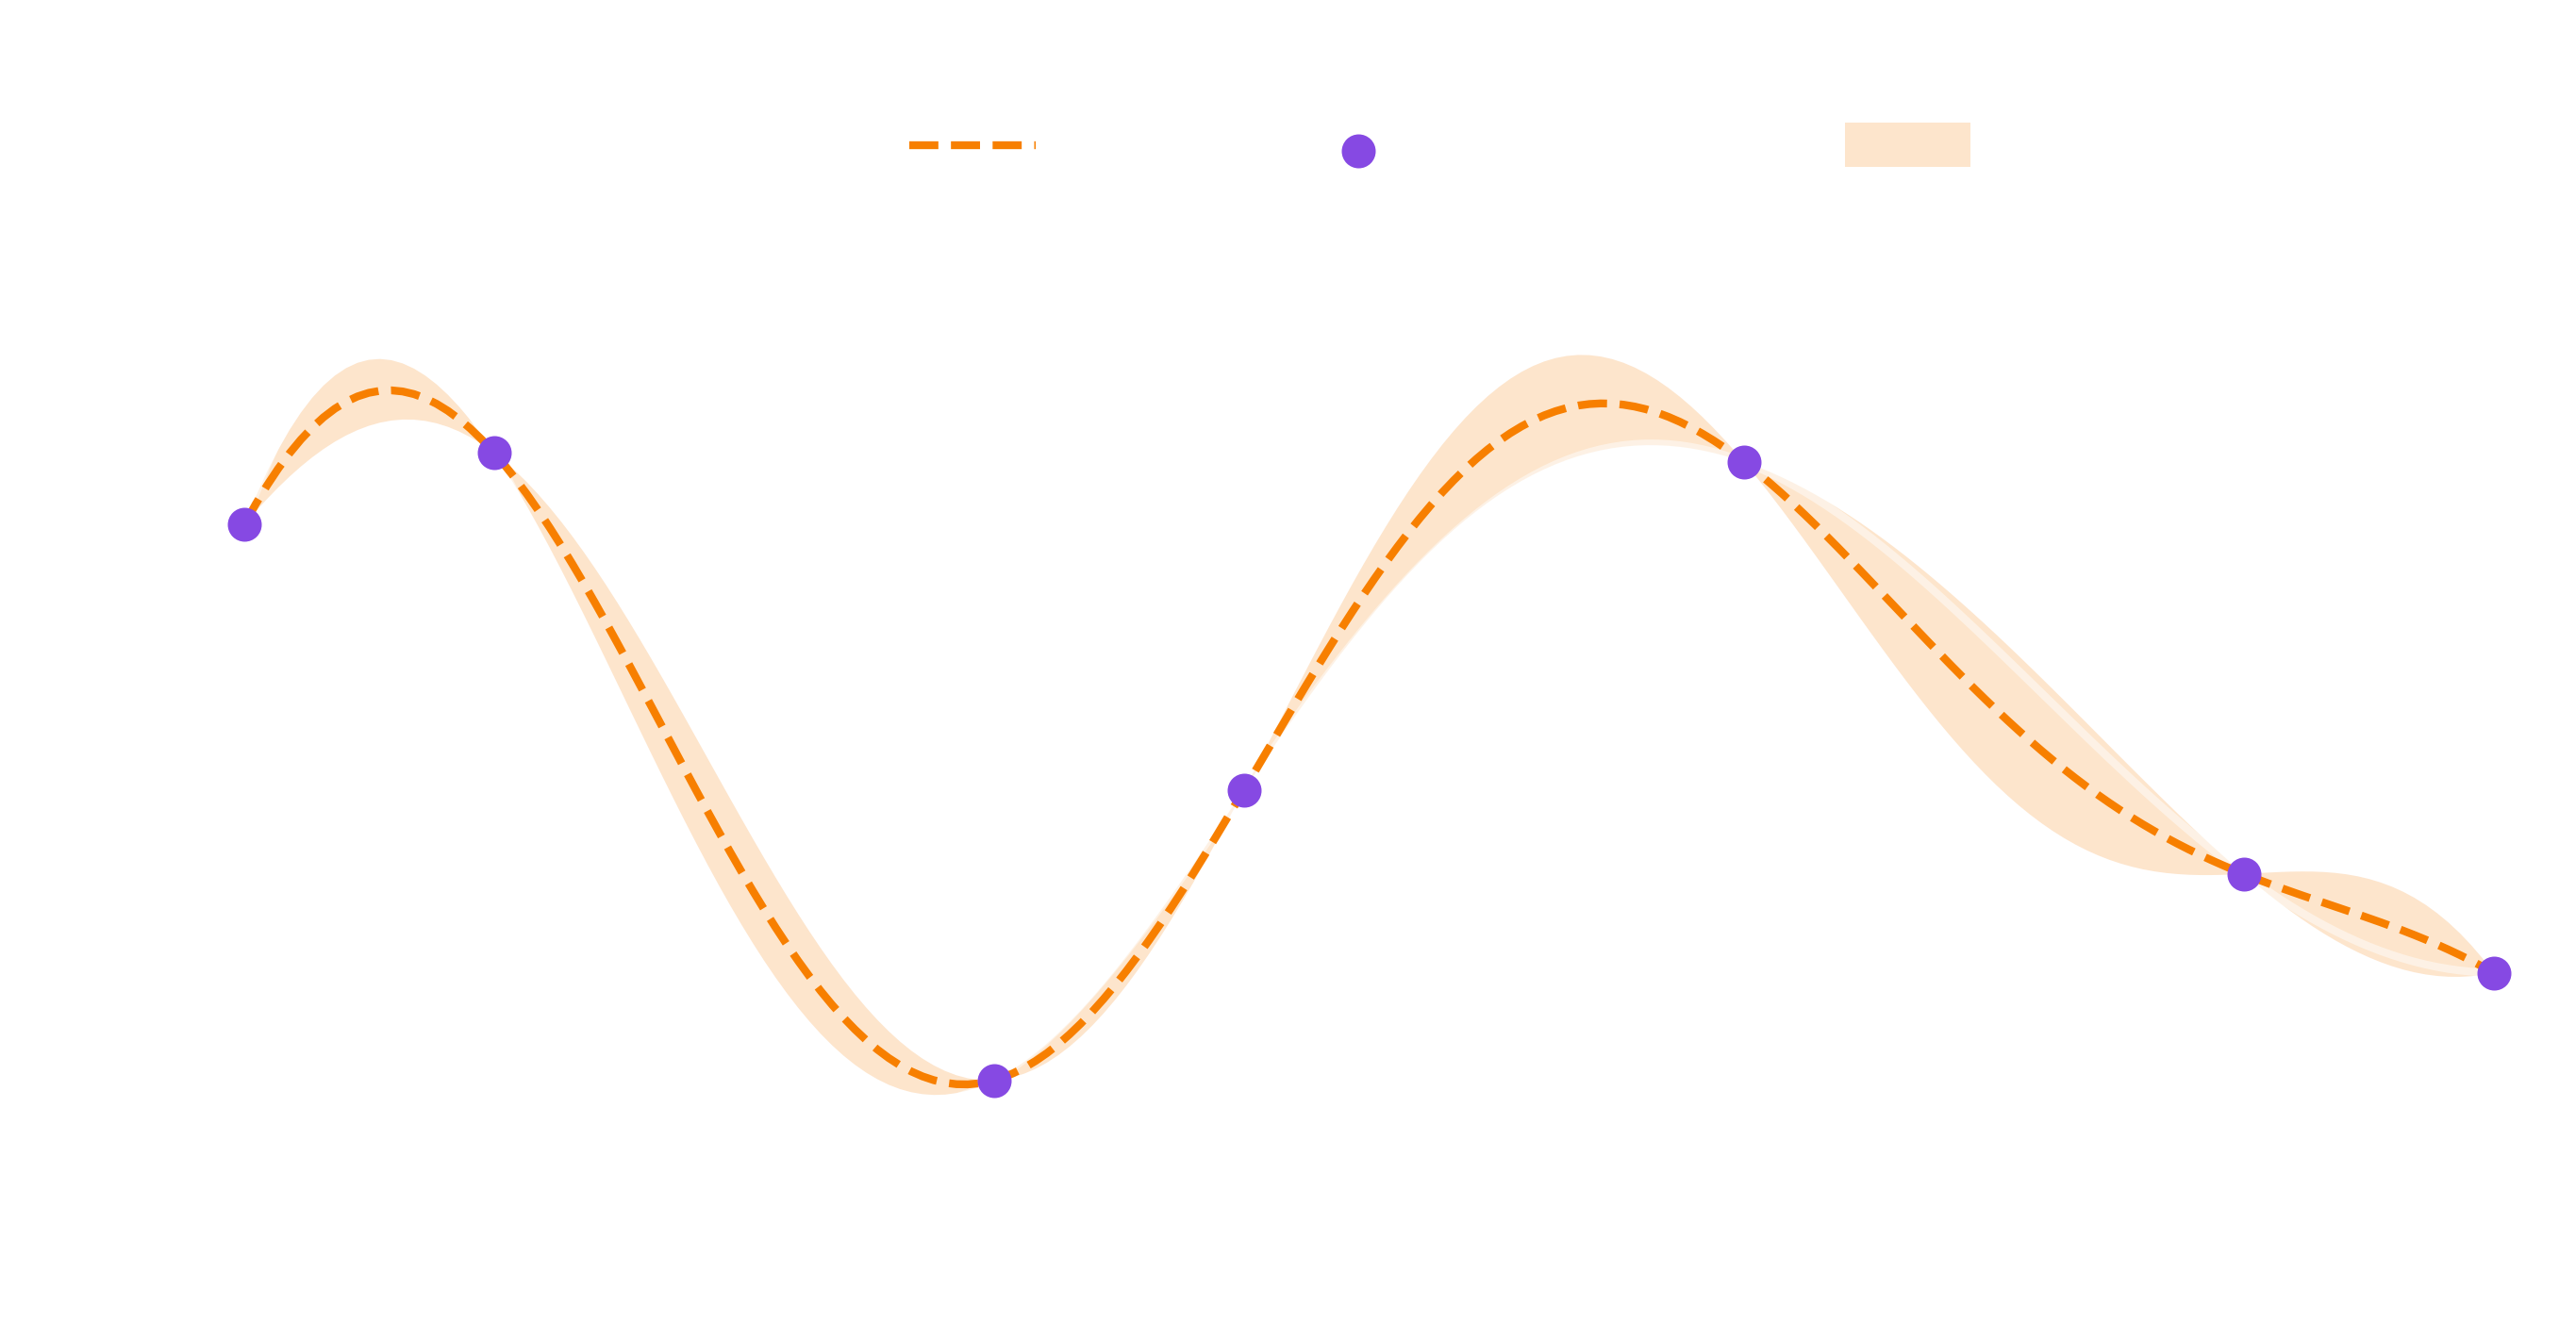

In [21]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

gp = GaussianProcessRegressor(kernel=C() * RBF())
gp.fit(np.atleast_2d(xs).T, ys)
y_pred, sigma = gp.predict(np.atleast_2d(x_fine).T, return_std=True)

upper, lower = y_pred + 1.96 * sigma, y_pred - 1.96 * sigma

plt.scatter(xs, ys, s=30, label="Samples", zorder=20)
plt.plot(x_fine, y_fine, label="Function", color="w", alpha=0.5)
plt.plot(x_fine, y_pred, label="GP")
plt.fill_between(x_fine, upper, lower, alpha=0.2, label="95% confidence")
plt.legend(ncol=4, fontsize=12);
plt.ylim(3.4, 5.5); ###REMOVE

!!!main

## Gaussian Processes with uncertainty

Conceptually, what if our data points have uncertainty. Under the hood, what we're doing is adding in an extra covariance matrix into the mix, where for our independent uncertainty will be a diagonal matrix. Formally, this is called Tikhonov regularization, but lets not get into that.

Let's generate some data points with different uncertainty on each point:

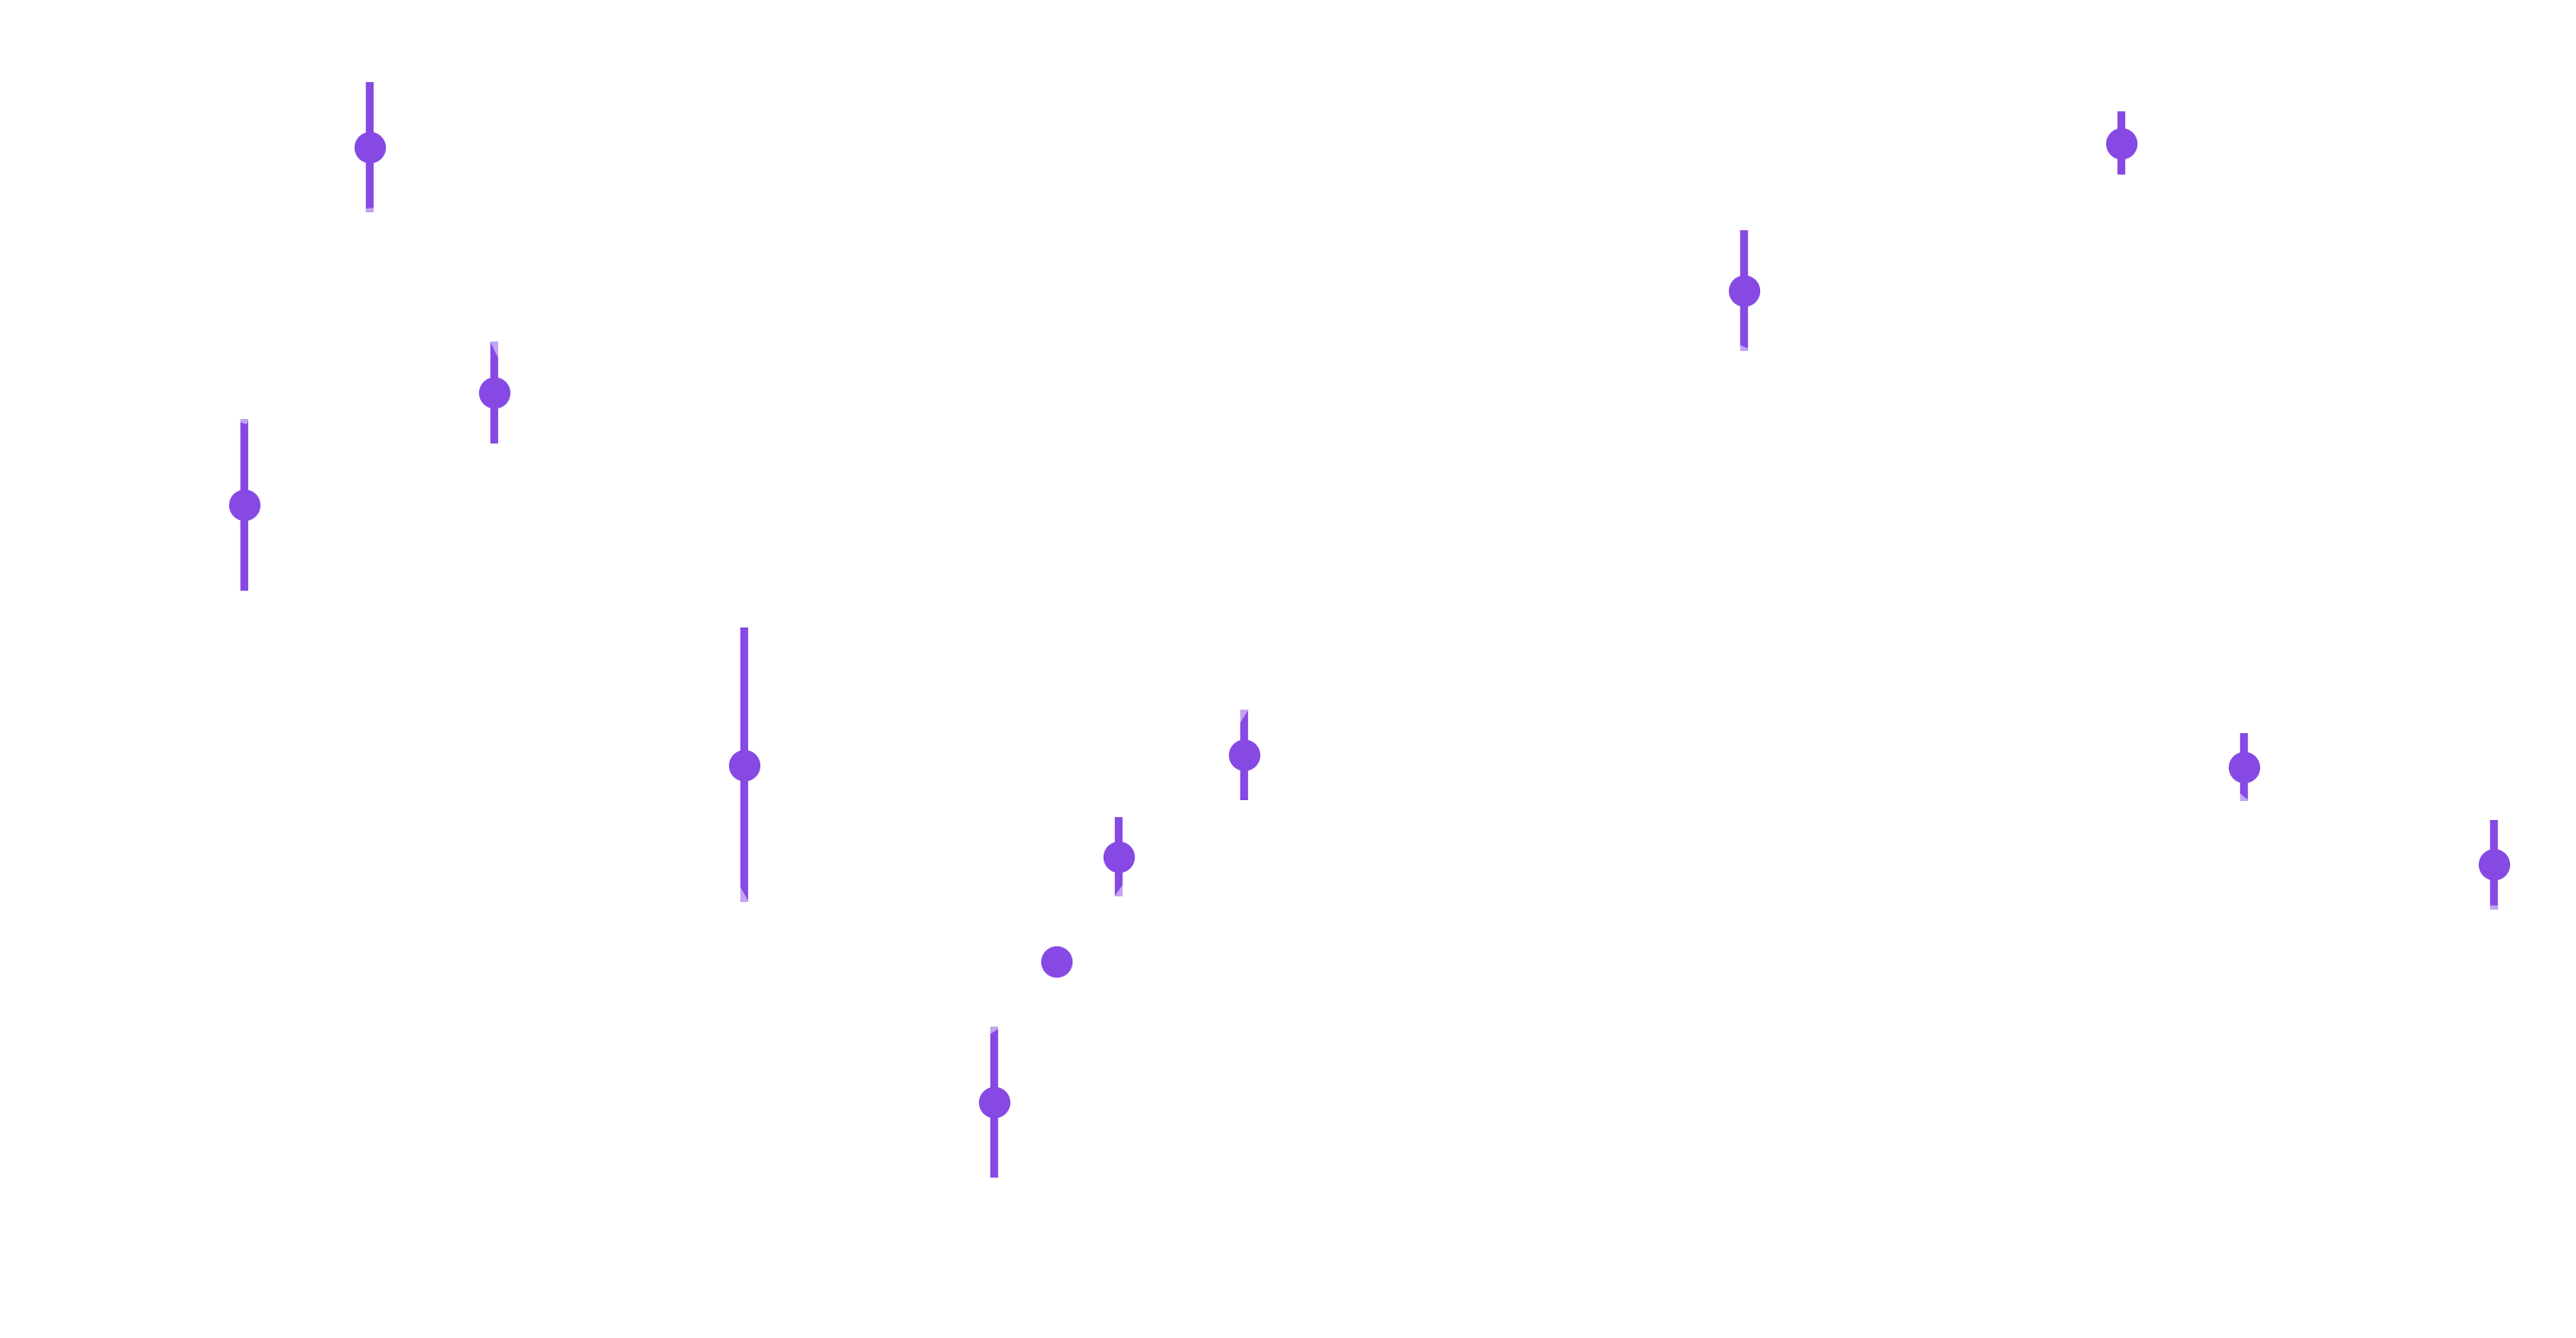

In [22]:
np.random.seed(1) ###REMOVE
xs2 = np.array([1, 1.5, 2, 3, 4, 4.25, 4.5, 5, 7, 9, 10])
ys2 = fn(xs2)

err_scale = np.random.uniform(low=0.1, high=0.2, size=ys2.shape)
err = np.random.normal(loc=0, scale=err_scale, size=ys2.shape)
ys_err = ys2 + err

plt.errorbar(xs2, ys_err, yerr=err, fmt="o", label="Samples", markersize=5)
plt.plot(x_fine, y_fine, label="Function", color="w", alpha=0.5, linestyle="-")
plt.legend(ncol=4, fontsize=12);


We can add this uncertainty on the y-axis in incredibly easily - we just pass it in when we create the Gaussian Process.

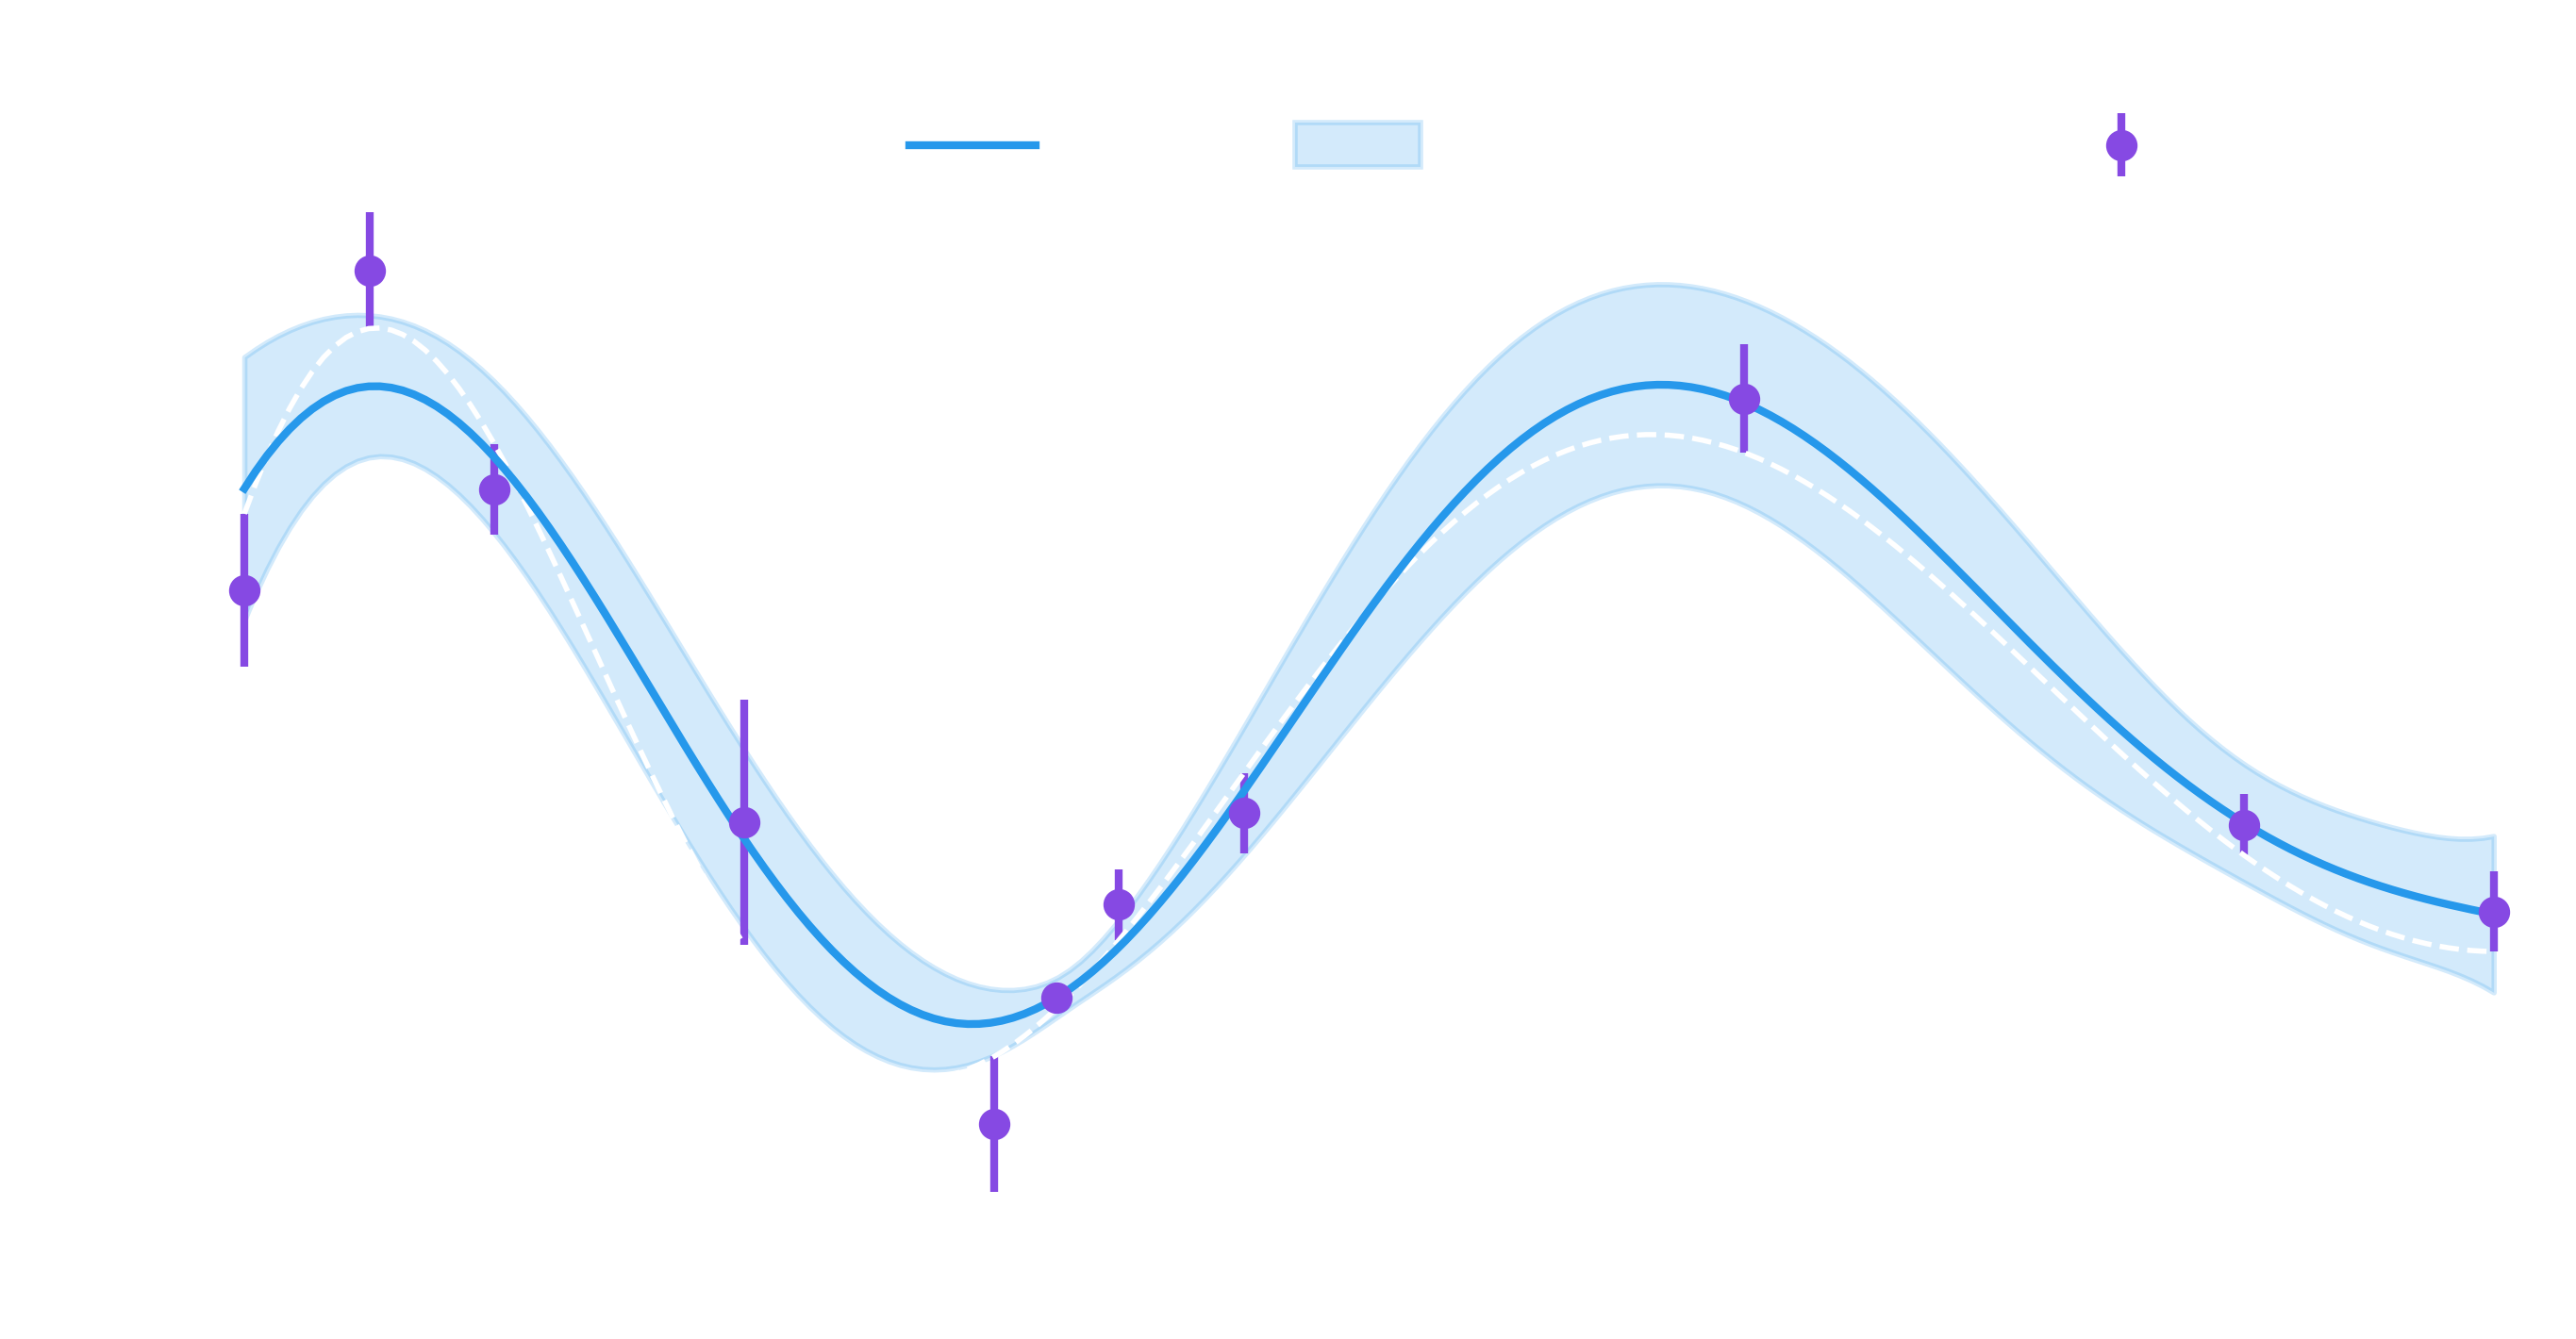

In [23]:
gp = GaussianProcessRegressor(kernel=C() * RBF(), alpha=err**2)
gp.fit(np.atleast_2d(xs2).T, ys_err)
y_pred, sigma = gp.predict(np.atleast_2d(x_fine).T, return_std=True)

# 1.96sigma = 95% confidence interval for a normal distribution
upper, lower = y_pred + 1.96 * sigma, y_pred - 1.96 * sigma

plt.errorbar(xs2, ys_err, yerr=err, fmt="o", label="Samples", markersize=5)
plt.plot(x_fine, y_fine, label="Function", color="w", lw=1)
plt.plot(x_fine, y_pred, label="GP", ls="-")
plt.fill_between(x_fine, upper, lower, alpha=0.2, label="95% confidence", color="#2698eb")
plt.ylim(3.35, 5.5), plt.legend(ncol=4, fontsize=12);

# Summary 

If you've reach this point and actually gone through all the code and writing, congratulations! Probably my longest write up yet, but if you've made it here, hopefully Gaussian Processes, kernels and covariance are all more comfortable terms than when you started.

Whilst they might be easy to plug-and-play using scikit-learn, Gaussian proccesses require subtlety in training, especially picking the right kernel. Its a very deep and rich field that you can easily spend an entire PhD investigating.